In [28]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}
df = pd.read_csv("mnist_dataset.csv", dtype=dtype_map)  # Update the path as needed

labels = torch.from_numpy(df['label'].values).to(torch.long)
pixels = torch.from_numpy(df.iloc[:, 1:].values).to(torch.float32)  # normalize in-place

indices = torch.arange(len(labels))
train_idx, test_idx = train_test_split(indices.numpy(), test_size=0.01, shuffle=True)

input_train = pixels[train_idx].to(device, non_blocking=True)
output_train = labels[train_idx].to(device, non_blocking=True)
input_test = pixels[test_idx].to(device, non_blocking=True)
output_test = labels[test_idx].to(device, non_blocking=True)

print("Train X:", input_train.shape)
print("Train Y:", output_train.shape)
print("Test X:", input_test.shape)
print("Test Y:", output_test.shape)

cuda
Train X: torch.Size([69300, 784])
Train Y: torch.Size([69300])
Test X: torch.Size([700, 784])
Test Y: torch.Size([700])


In [29]:
class LayerBlock(nn.Module):
    def __init__(self, input_size, output_size, activation='relu'):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, bias=True)
        self.activation_name = activation.lower()

    def forward(self, x):
        z = self.linear(x)

        if self.activation_name == 'relu':
            return F.relu(z)
        elif self.activation_name == 'sigmoid':
            return torch.sigmoid(z)
        elif self.activation_name == 'softmax':
            return F.softmax(z, dim=1)
        else:
            return z  # Linear activation

In [30]:
class NNModel(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layer_sizes = layer_sizes
        for i in range(len(layer_sizes) - 1):
            activation = 'relu'
            if i == 0:
                activation = 'sigmoid'
            elif i == len(layer_sizes) - 2:
                activation = 'softmax'
            self.layers.append(LayerBlock(layer_sizes[i], layer_sizes[i + 1], activation))
        self.activations = {}

    def forward(self, x, store_activations=False):
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if store_activations:
                self.activations[idx] = x.detach().cpu().numpy()
        return x

In [31]:
model = NNModel([784, 121, 25, 10]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Example training step
def train_one_epoch(model, optimizer, criterion, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [32]:
# Pick an example index from training set
example_idx = 0  # Change this to any index you want
example_img = input_train[example_idx].unsqueeze(0)  # shape: [1, 784]
example_label = output_train[example_idx].item()

# Vector database to store activations for each epoch
vector_db = {}

In [33]:
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer, loss_fn, max_epochs=50):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.max_epochs = max_epochs
        self.loss_history = []

    def train(self, x_train, y_train, example_img = None):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        for epoch in range(self.max_epochs):
            self.model.train()
            self.optimizer.zero_grad()

            logits = self.model(x_train)
            loss = self.loss_fn(logits, y_train)

            loss.backward()
            self.optimizer.step()

            self.loss_history.append(loss.item())

            # Store activations for the example image
            if example_img is not None:
                self.model.eval()
                _ = self.model(example_img.to(device), store_activations=True)
                vector_db[epoch] = {k: v.copy() for k, v in self.model.activations.items()}

            if epoch % 5 == 0 or epoch == self.max_epochs - 1:
                print(f"Epoch {epoch + 1}/{self.max_epochs} - Loss: {loss.item():.4f}")

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.grid(True)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

In [34]:
@torch.no_grad()
def evaluate(model, x, y):
    model.eval()
    x, y = x.to(device), y.to(device)
    pred = model(x).argmax(dim=1)
    acc = (pred == y).float().mean().item()
    print(f"Accuracy: {acc * 100:.2f}%")
    return acc

Epoch 1/100 - Loss: 2.3008
Epoch 6/100 - Loss: 2.2551
Epoch 11/100 - Loss: 2.2133
Epoch 16/100 - Loss: 2.1706
Epoch 21/100 - Loss: 2.1241
Epoch 26/100 - Loss: 2.0710
Epoch 31/100 - Loss: 2.0135
Epoch 36/100 - Loss: 1.9533
Epoch 41/100 - Loss: 1.8938
Epoch 46/100 - Loss: 1.8394
Epoch 51/100 - Loss: 1.7929
Epoch 56/100 - Loss: 1.7554
Epoch 61/100 - Loss: 1.7262
Epoch 66/100 - Loss: 1.7041
Epoch 71/100 - Loss: 1.6869
Epoch 76/100 - Loss: 1.6740
Epoch 81/100 - Loss: 1.6638
Epoch 86/100 - Loss: 1.6558
Epoch 91/100 - Loss: 1.6491
Epoch 96/100 - Loss: 1.6437
Epoch 100/100 - Loss: 1.6400


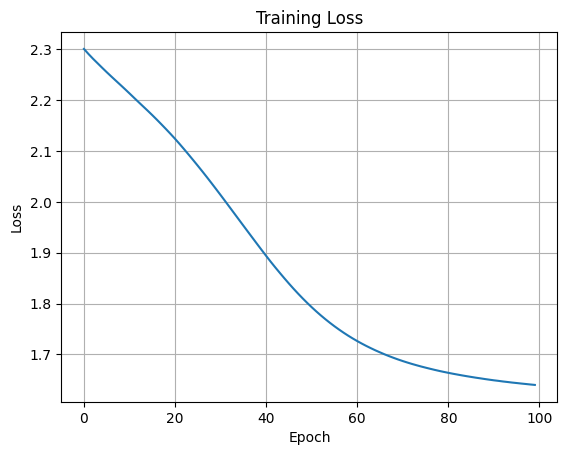

Accuracy: 83.29%


0.8328571319580078

In [35]:
# Build model
model = NNModel([784, 121, 25, 10]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
trainer = Trainer(model, optimizer, loss_fn, max_epochs=100)
trainer.train(input_train, output_train,example_img =example_img)
trainer.plot_loss()

# Evaluate
evaluate(model, input_test, output_test)

Input Image:


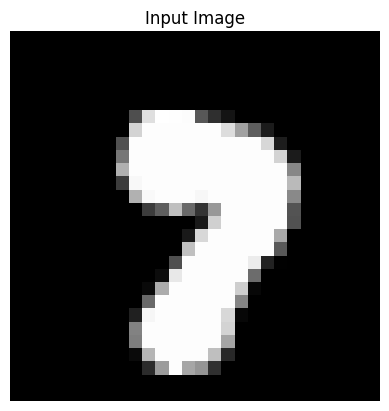


Epoch 1


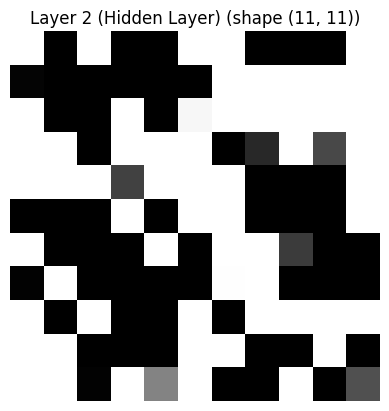

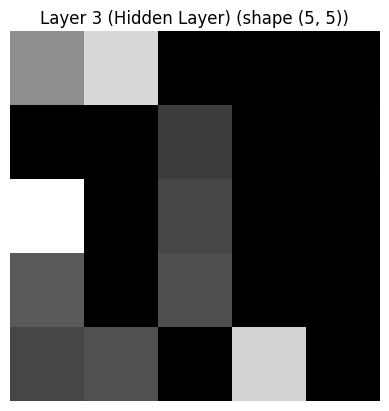

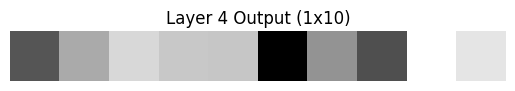


Epoch 2


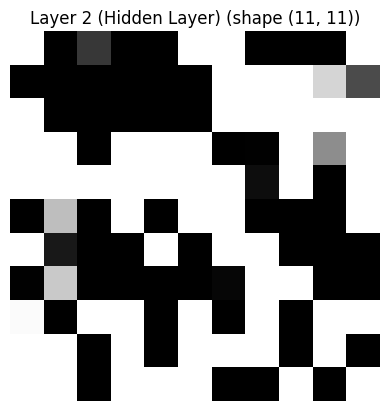

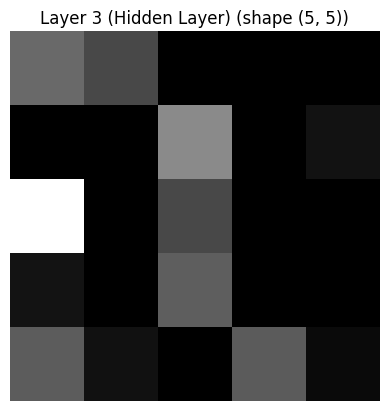

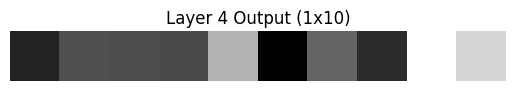


Epoch 3


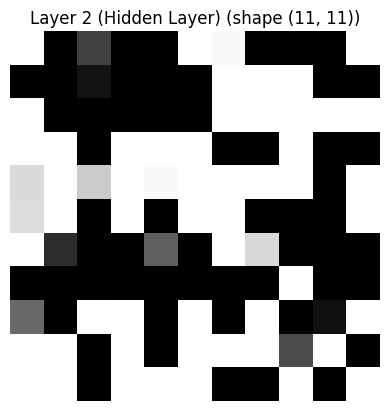

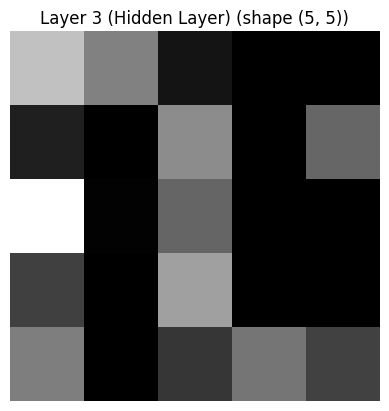

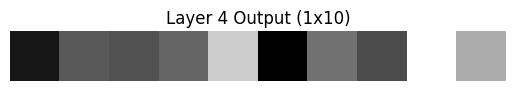


Epoch 4


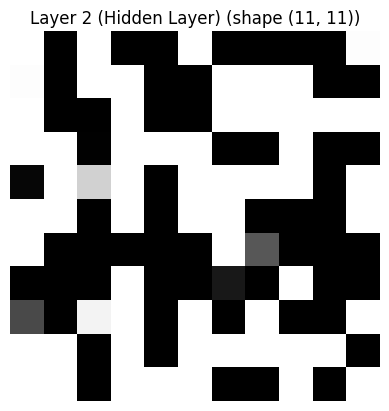

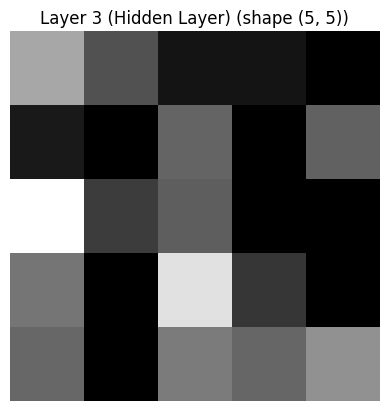

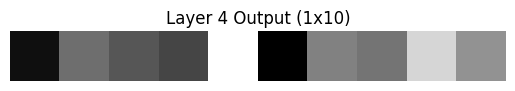


Epoch 5


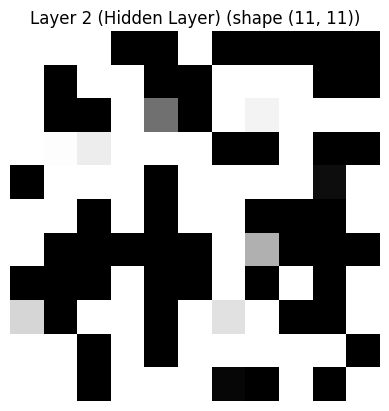

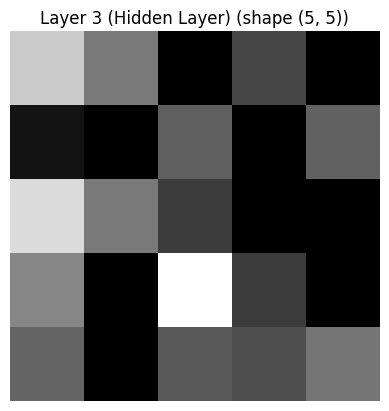

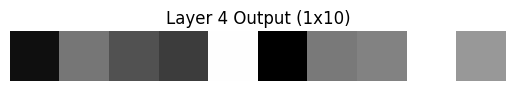


Epoch 6


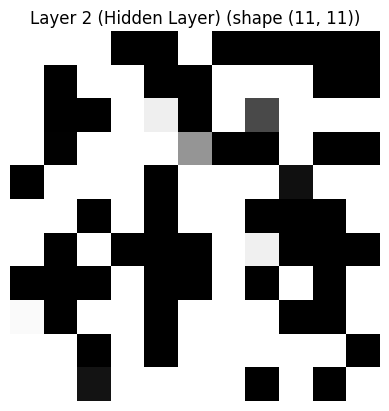

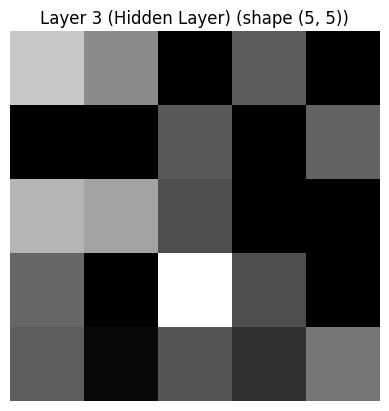

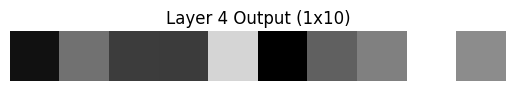


Epoch 7


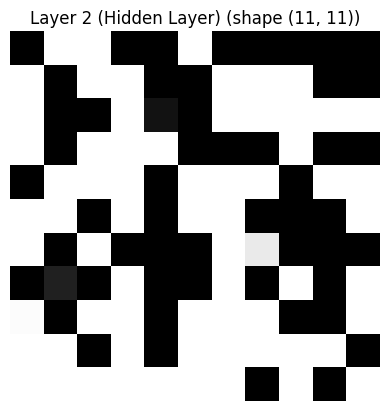

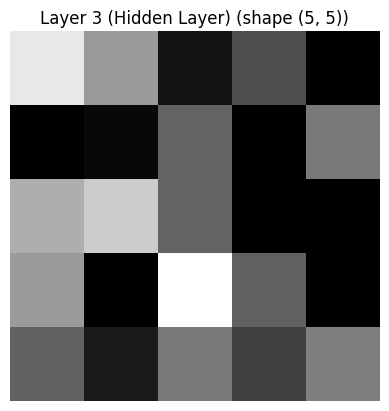

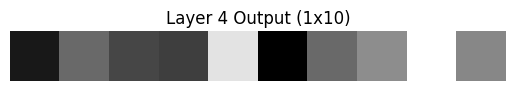


Epoch 8


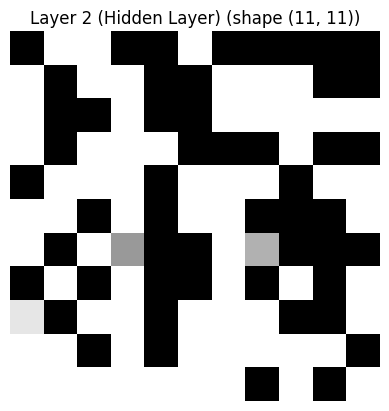

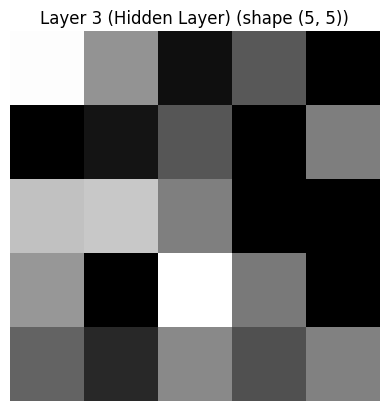

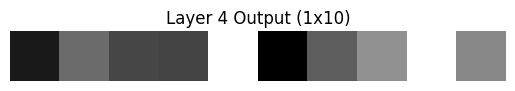


Epoch 9


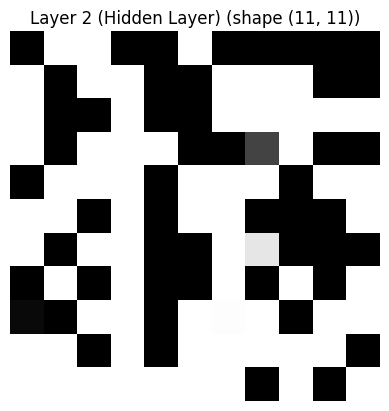

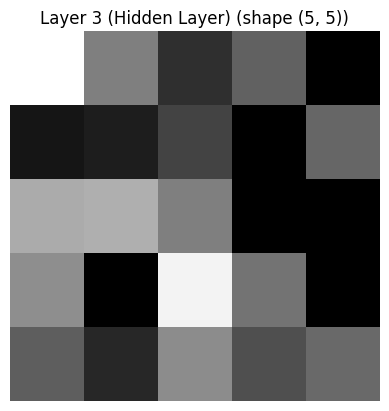

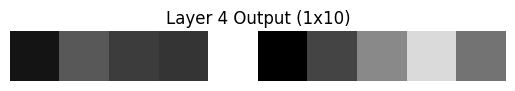


Epoch 10


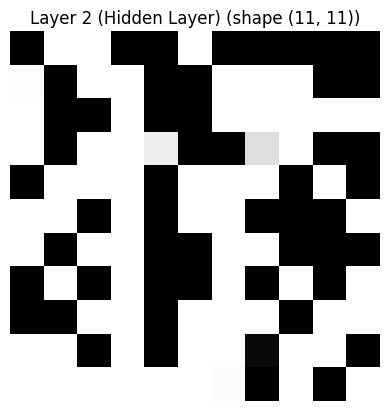

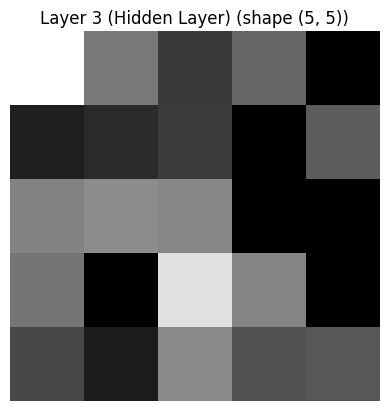

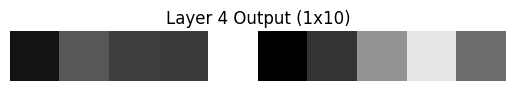


Epoch 11


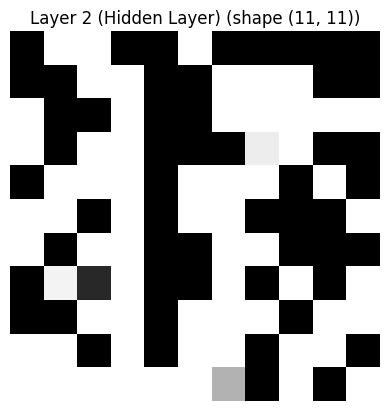

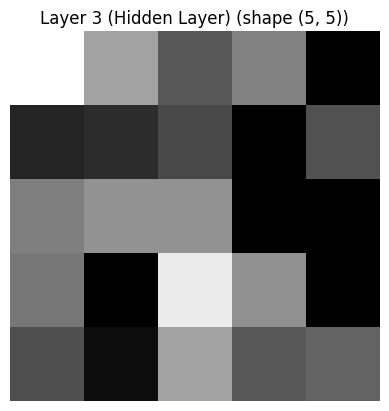

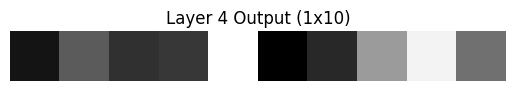


Epoch 12


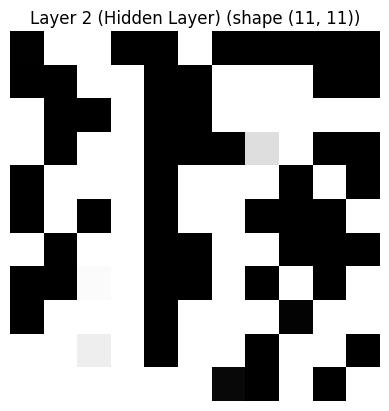

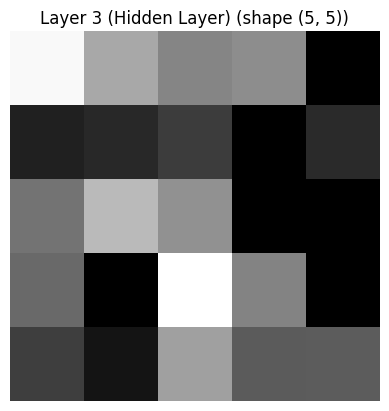

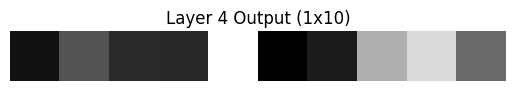


Epoch 13


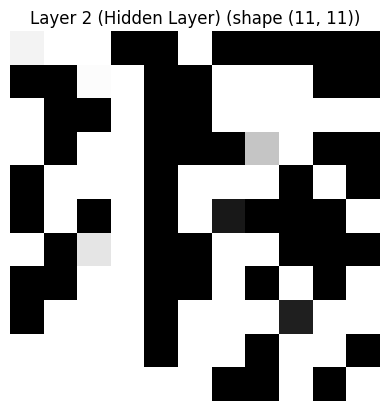

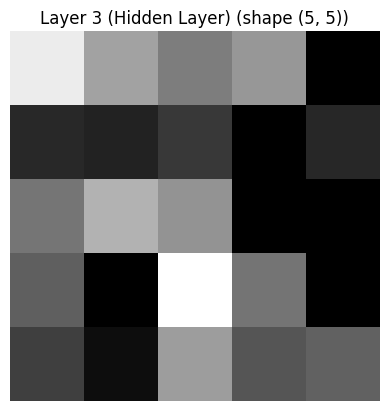

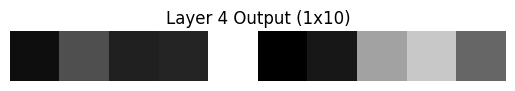


Epoch 14


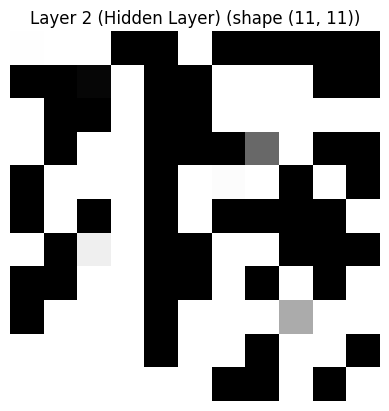

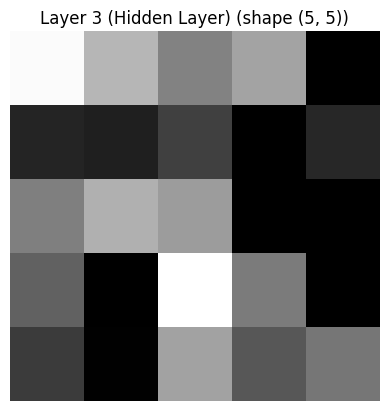

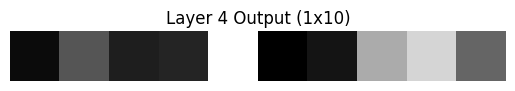


Epoch 15


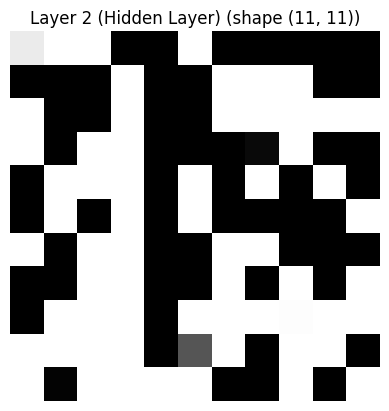

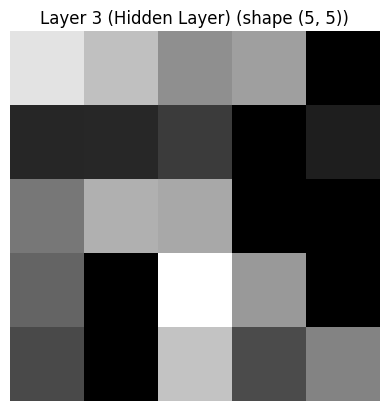

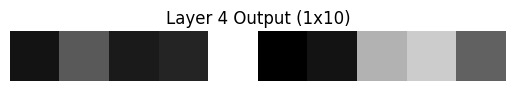


Epoch 16


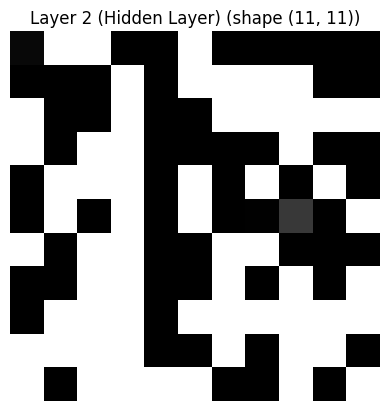

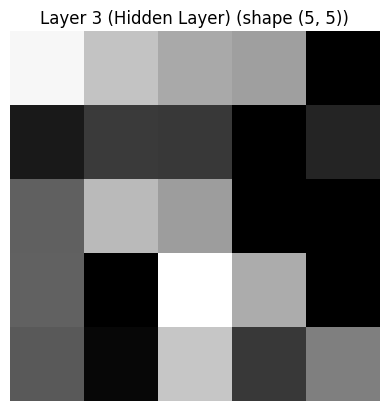

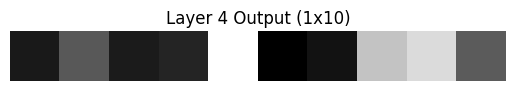


Epoch 17


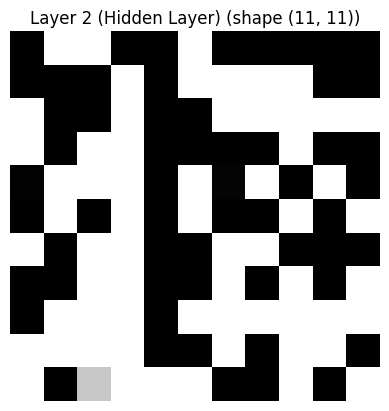

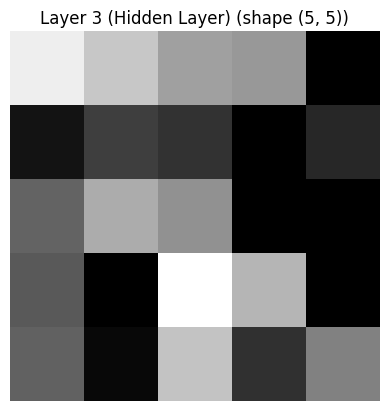

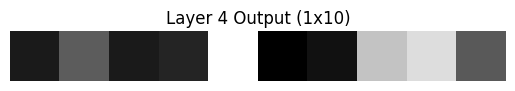


Epoch 18


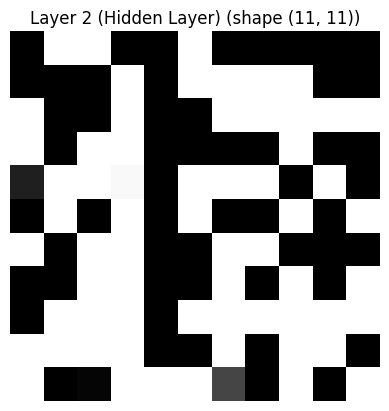

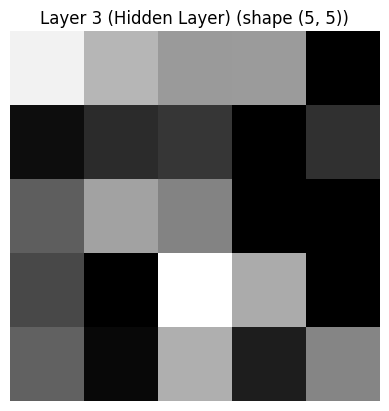

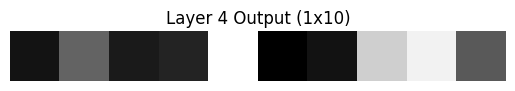


Epoch 19


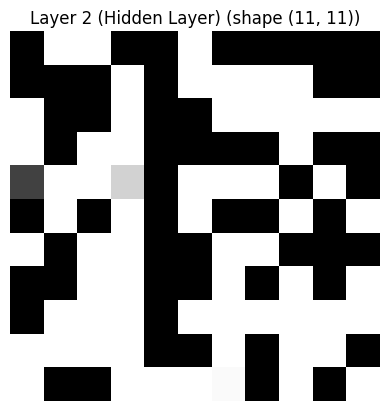

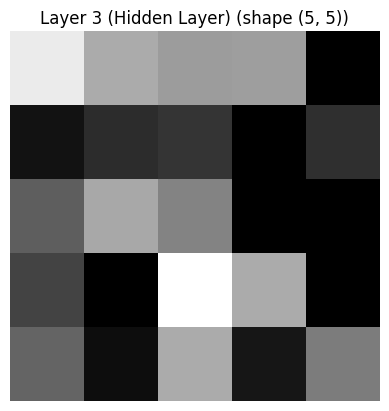

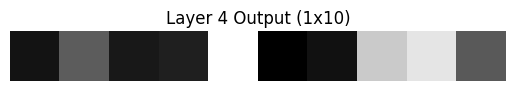


Epoch 20


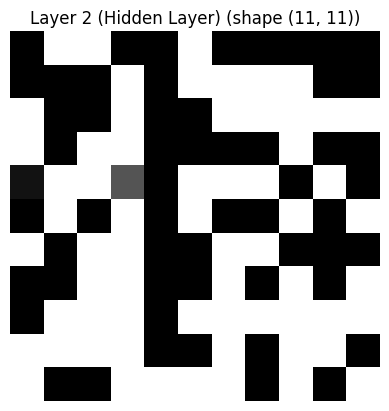

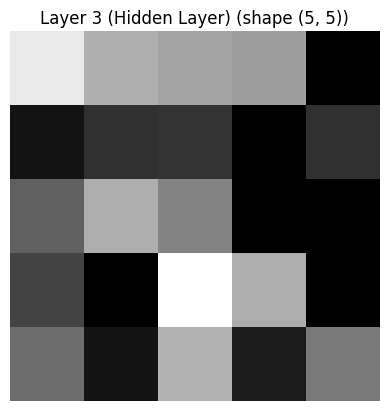

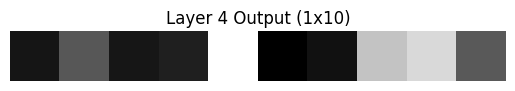


Epoch 21


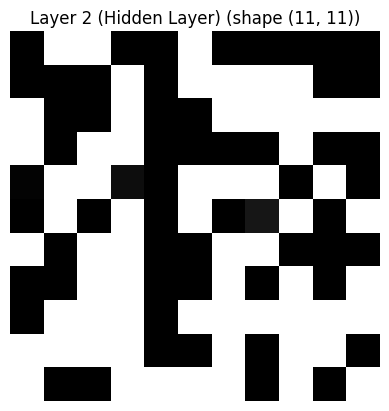

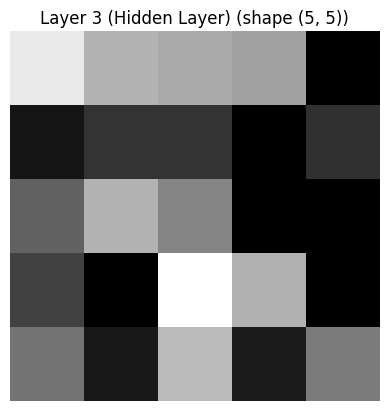

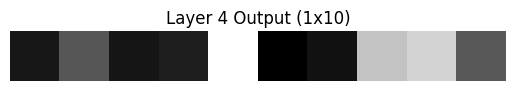


Epoch 22


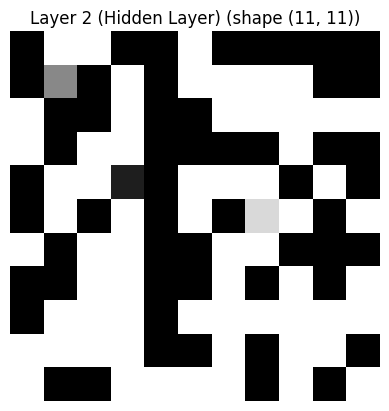

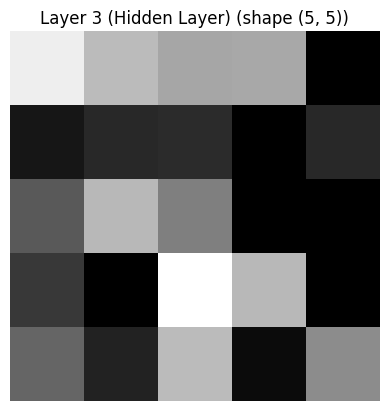

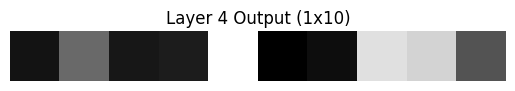


Epoch 23


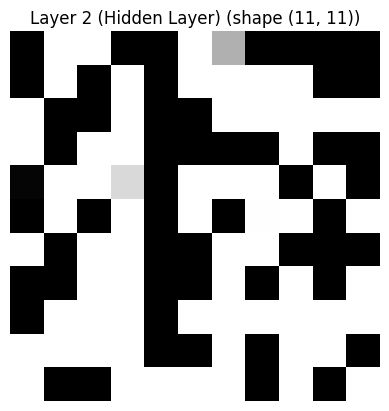

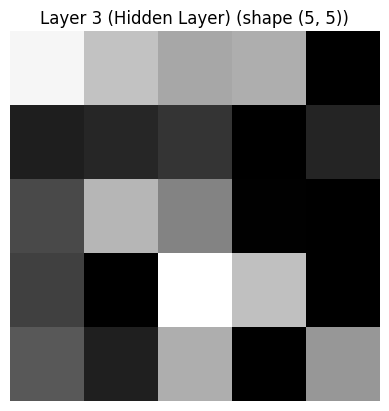

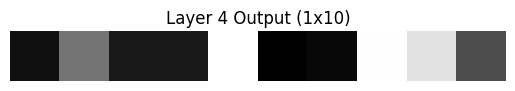


Epoch 24


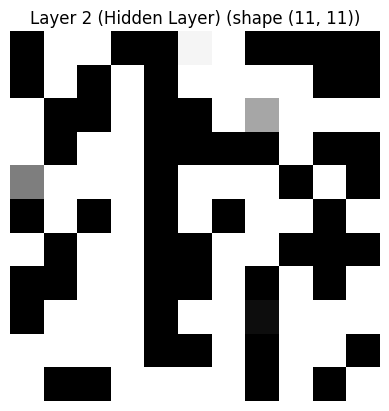

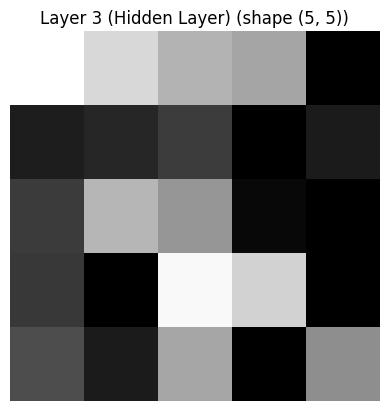

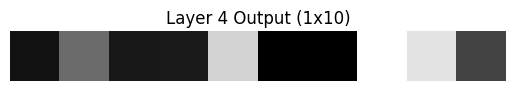


Epoch 25


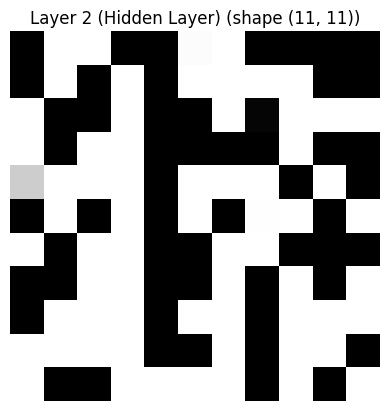

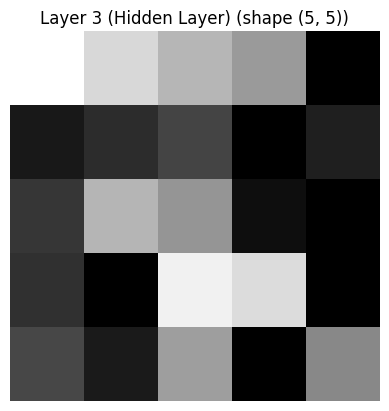

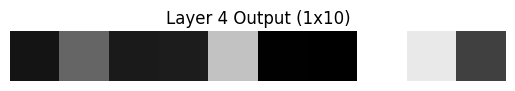


Epoch 26


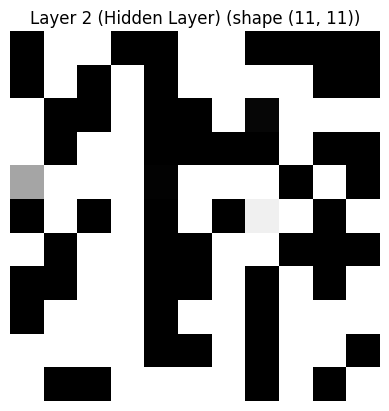

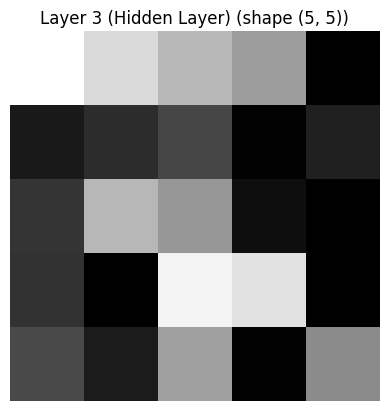

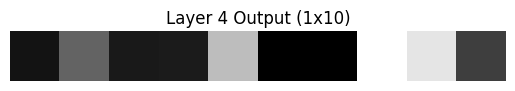


Epoch 27


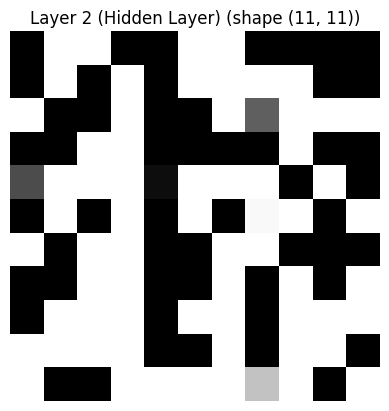

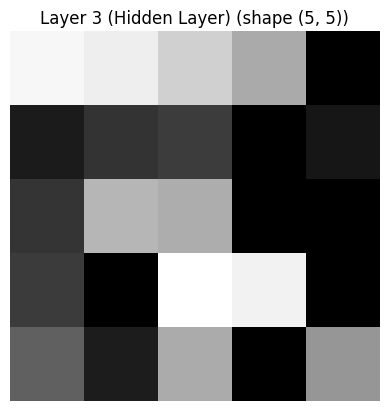

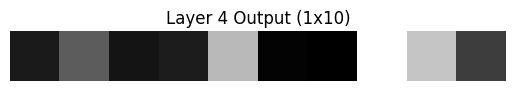


Epoch 28


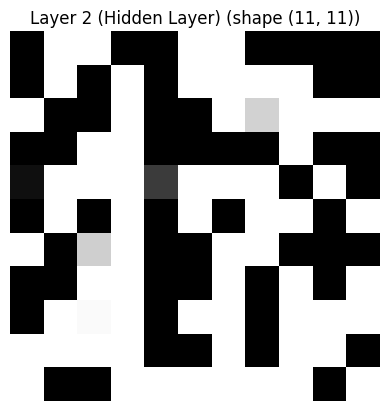

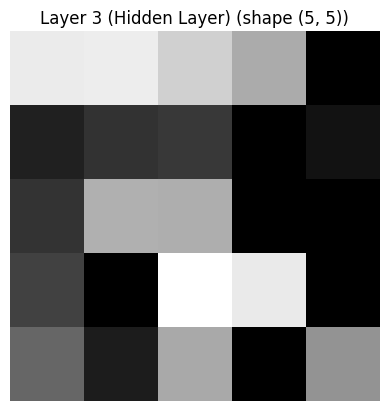

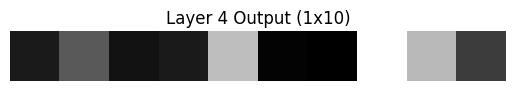


Epoch 29


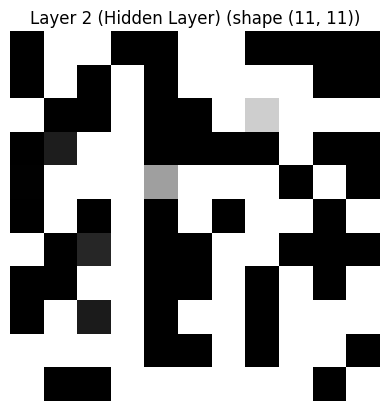

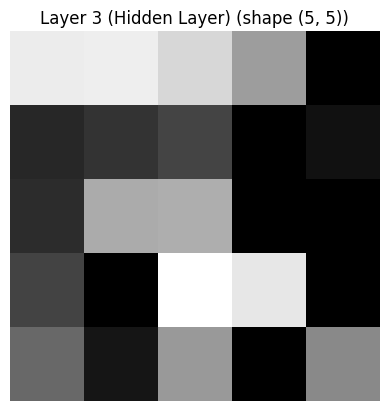

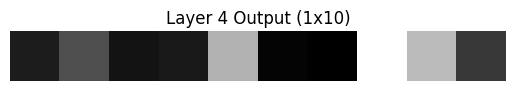


Epoch 30


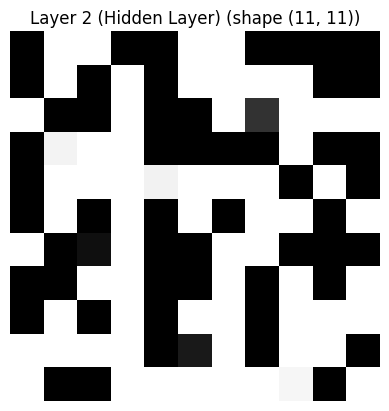

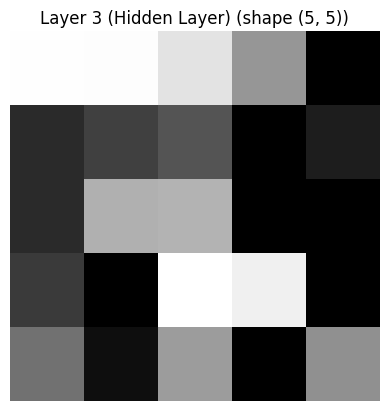

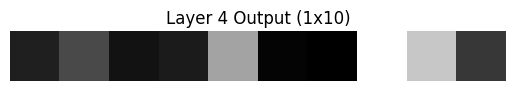


Epoch 31


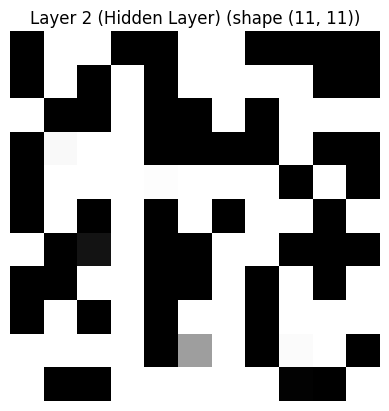

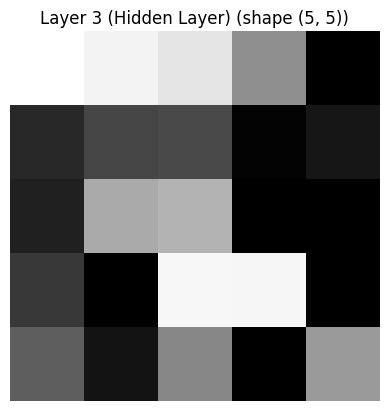

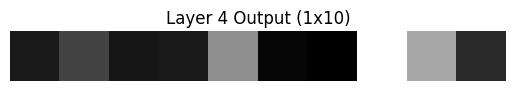


Epoch 32


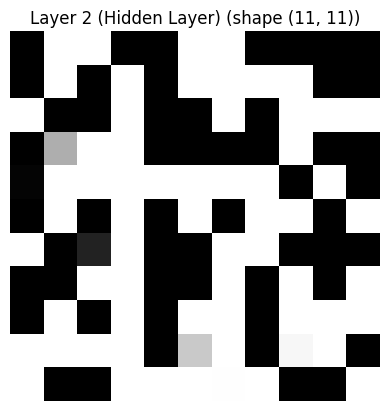

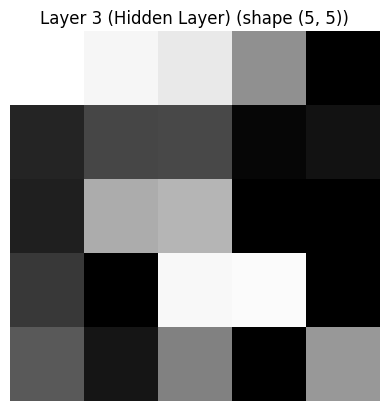

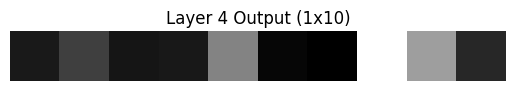


Epoch 33


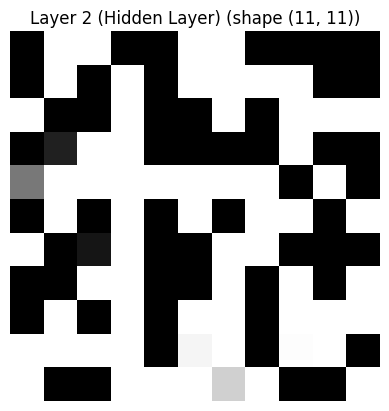

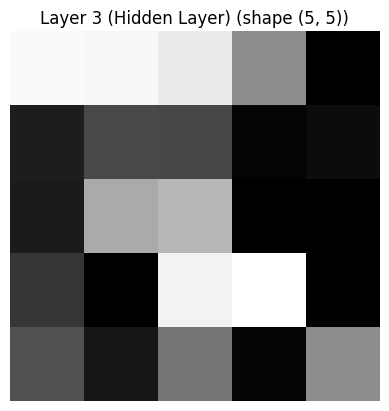

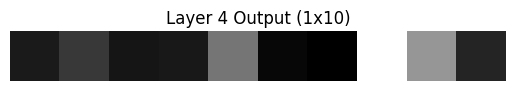


Epoch 34


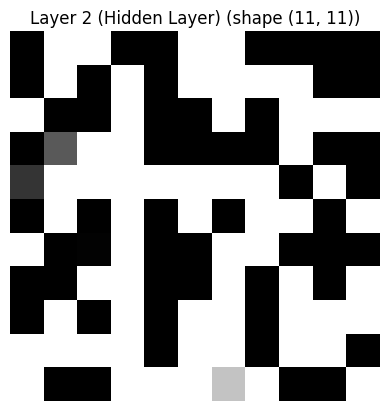

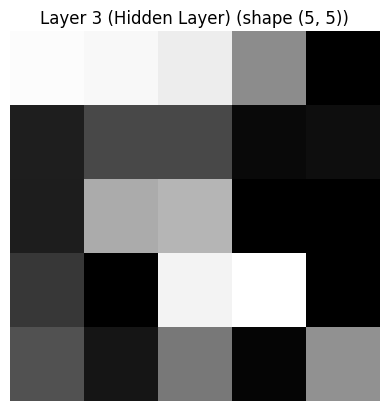

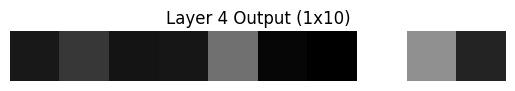


Epoch 35


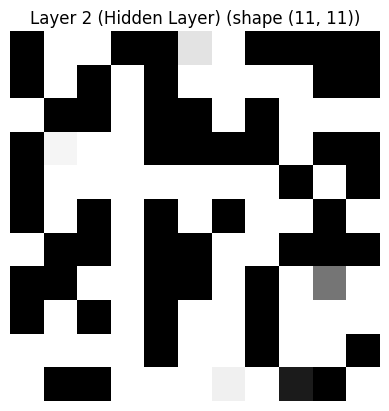

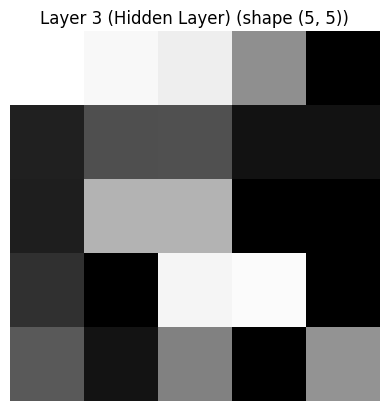

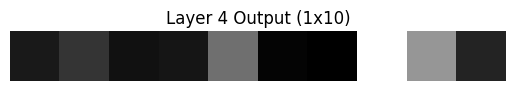


Epoch 36


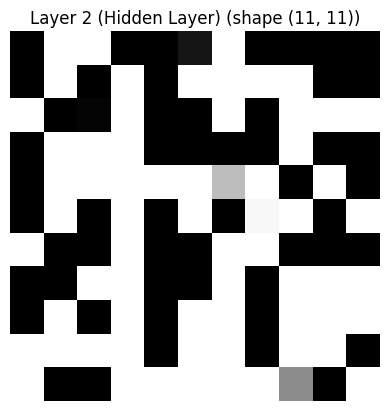

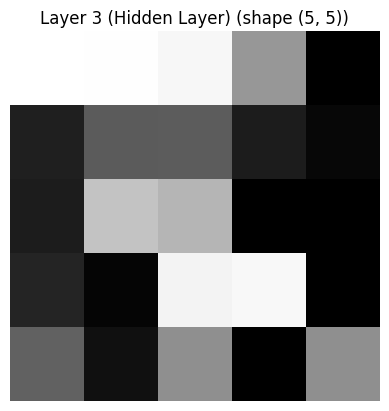

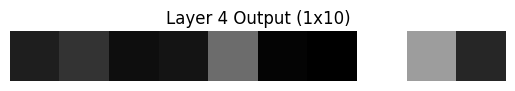


Epoch 37


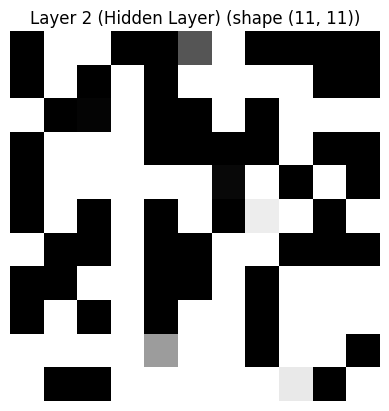

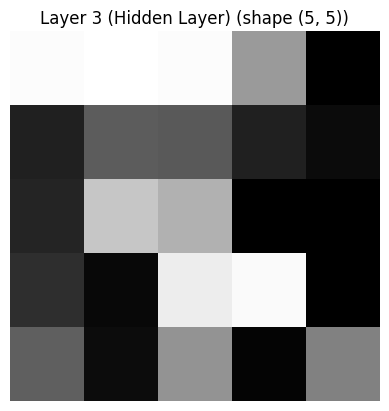

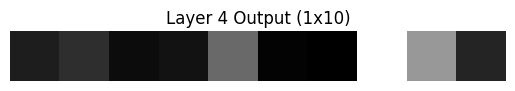


Epoch 38


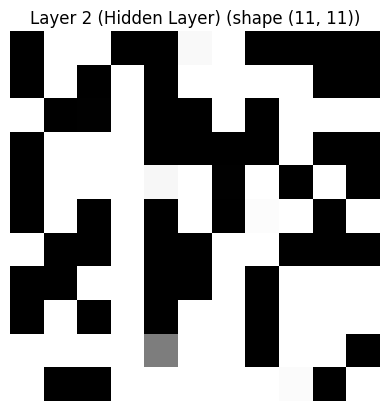

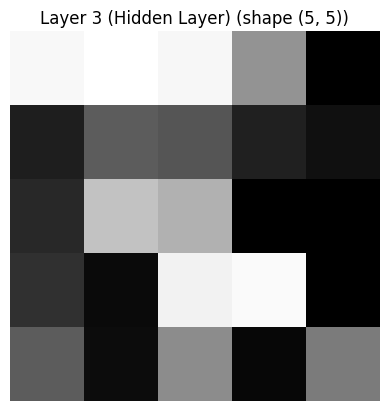

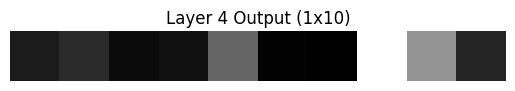


Epoch 39


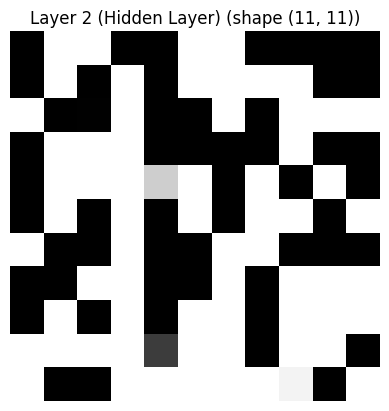

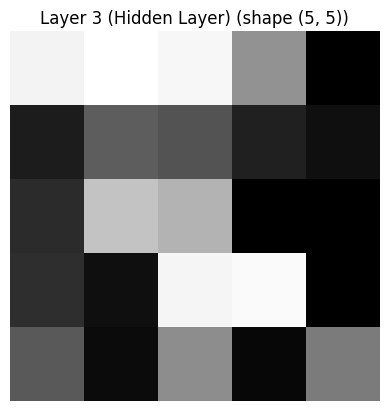

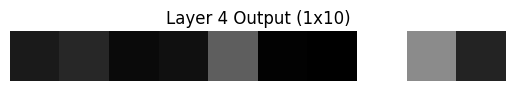


Epoch 40


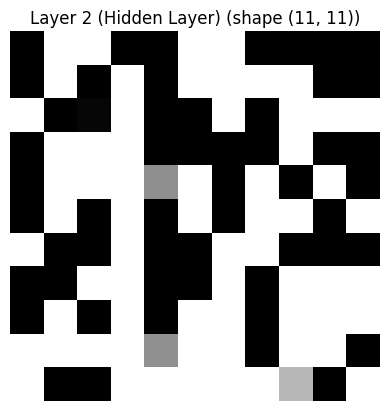

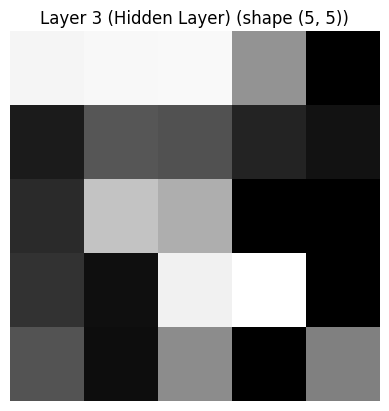

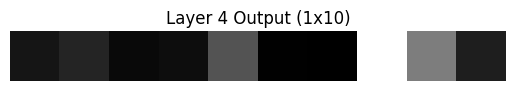


Epoch 41


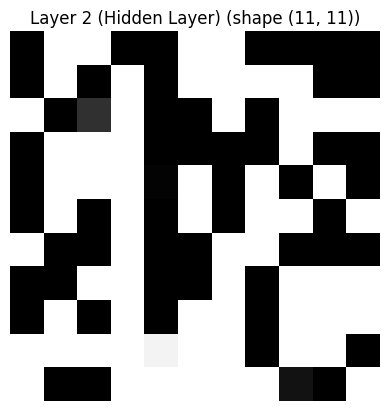

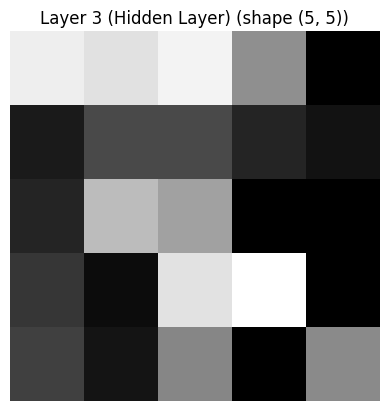

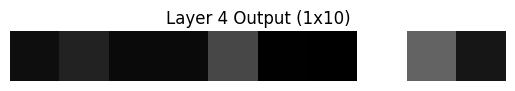


Epoch 42


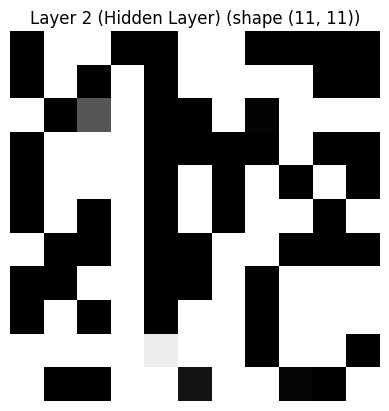

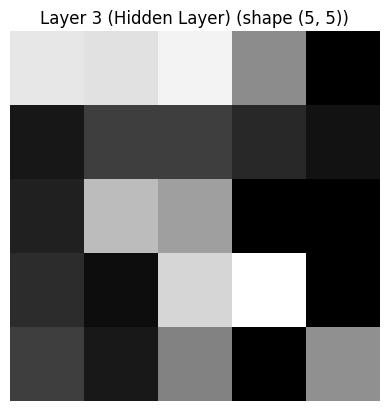

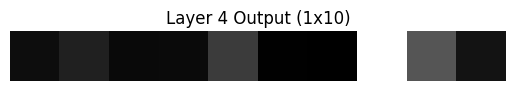


Epoch 43


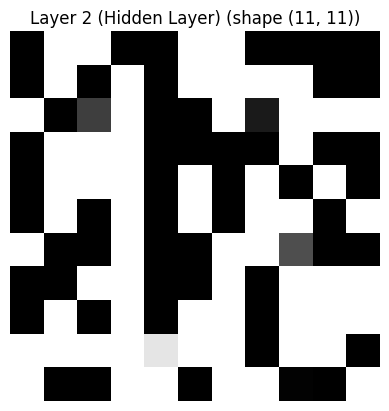

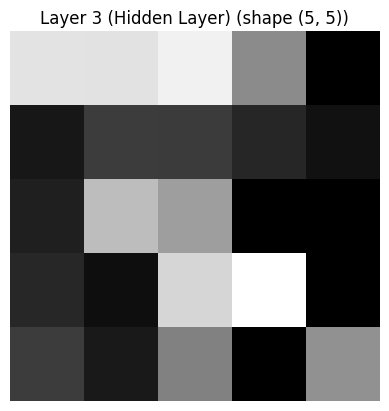

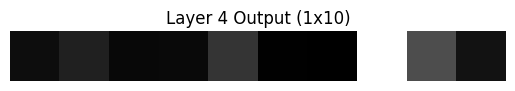


Epoch 44


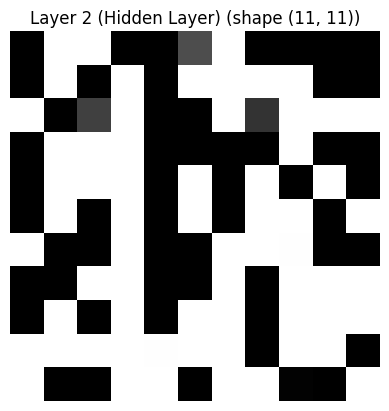

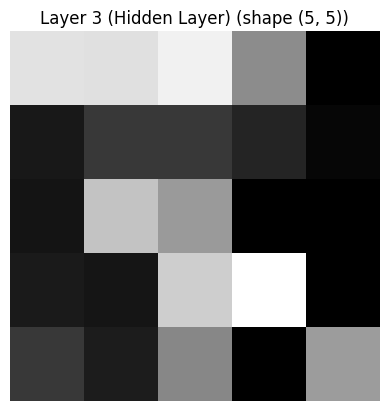

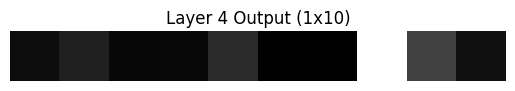


Epoch 45


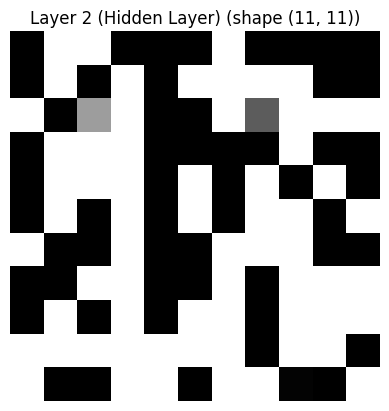

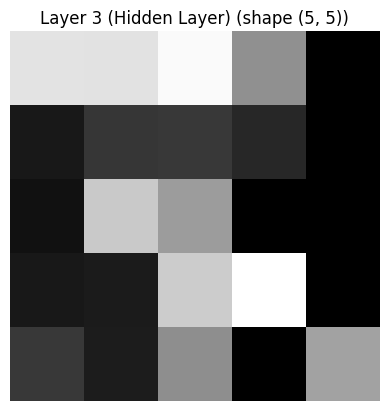

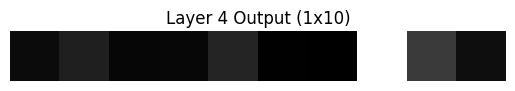


Epoch 46


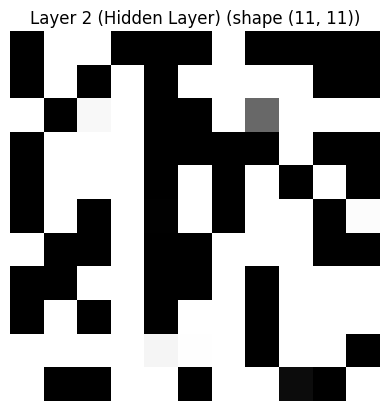

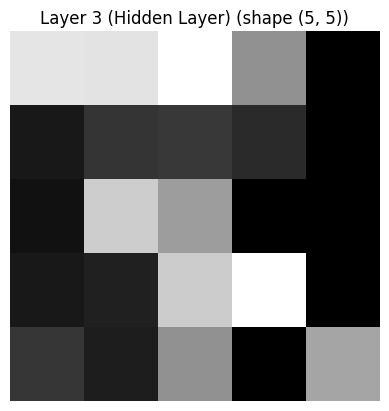

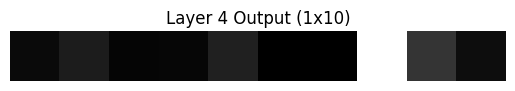


Epoch 47


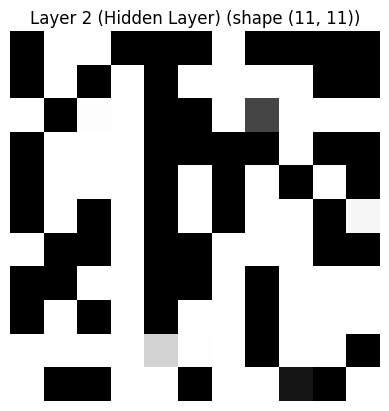

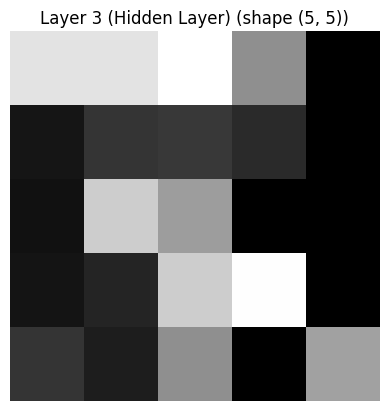

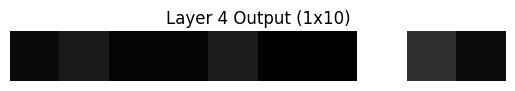


Epoch 48


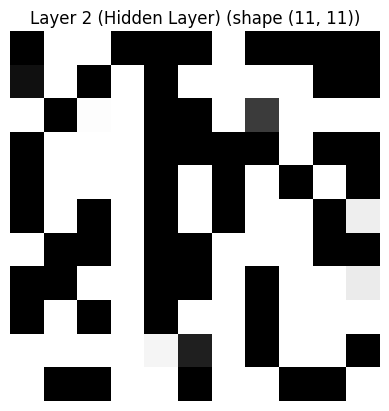

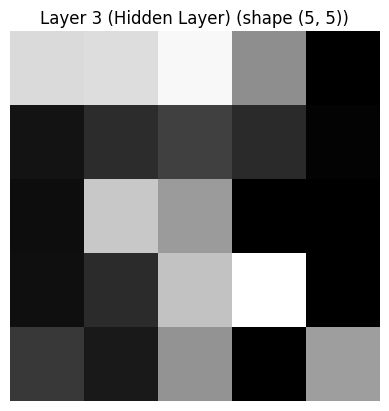

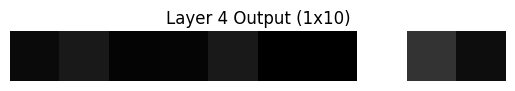


Epoch 49


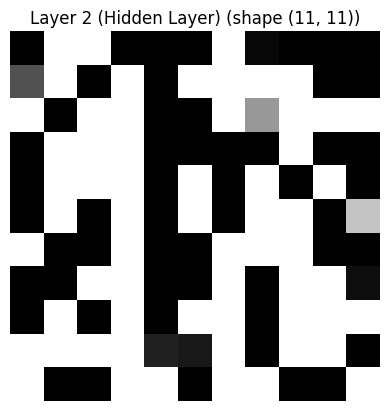

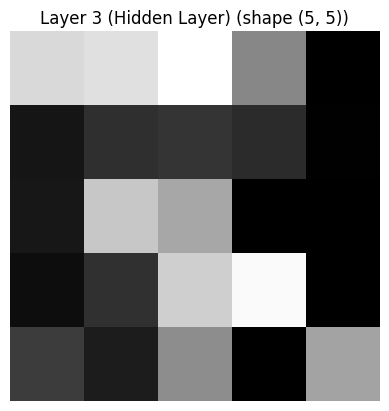

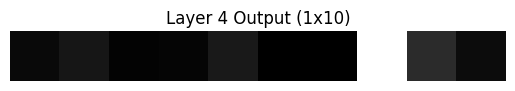


Epoch 50


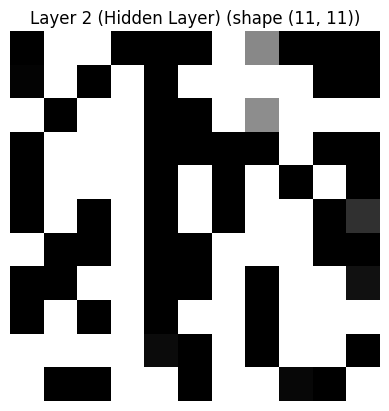

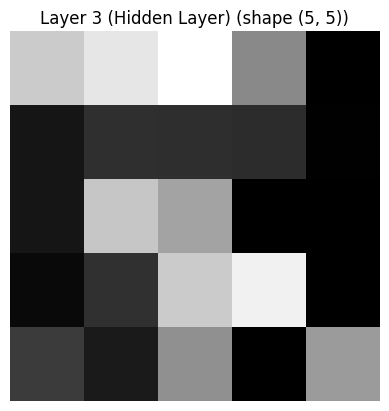

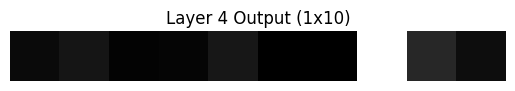


Epoch 51


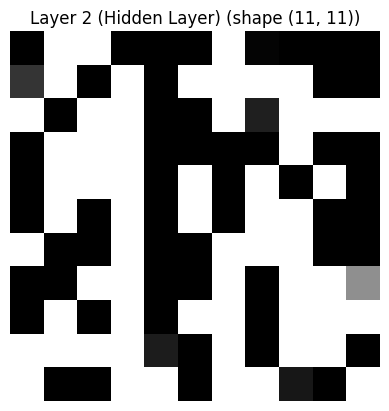

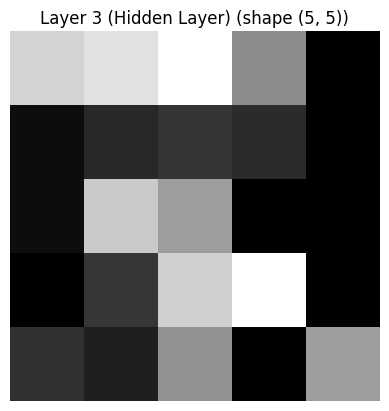

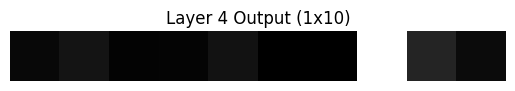


Epoch 52


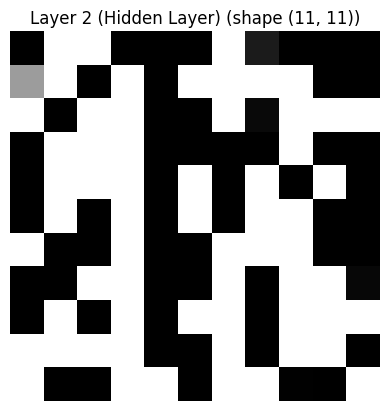

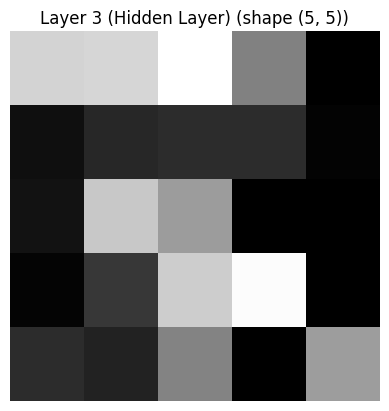

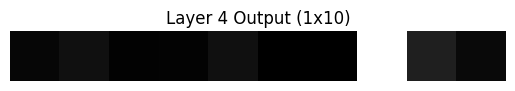


Epoch 53


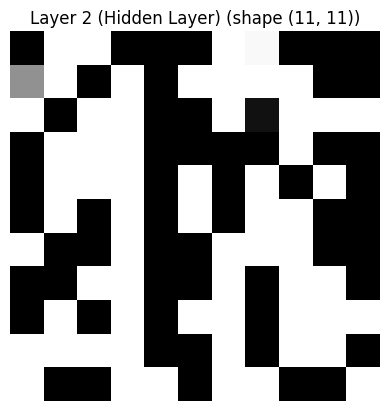

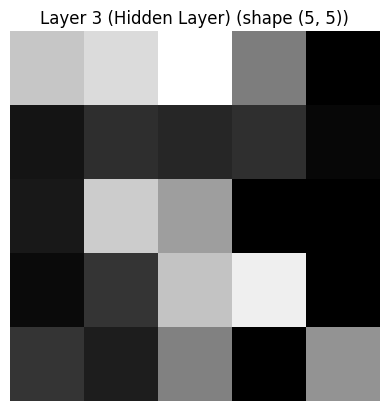

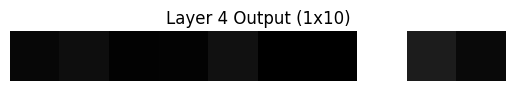


Epoch 54


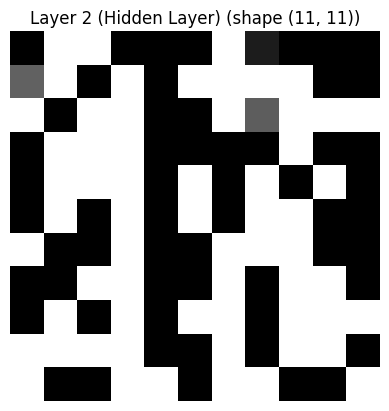

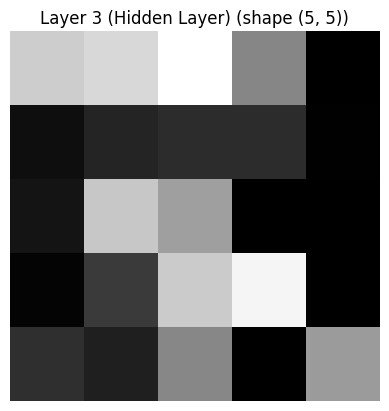

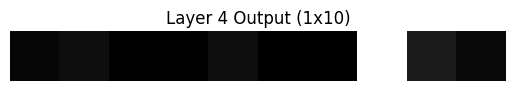


Epoch 55


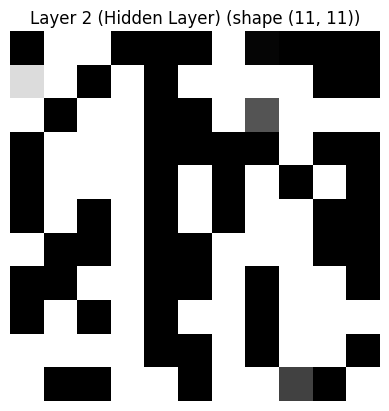

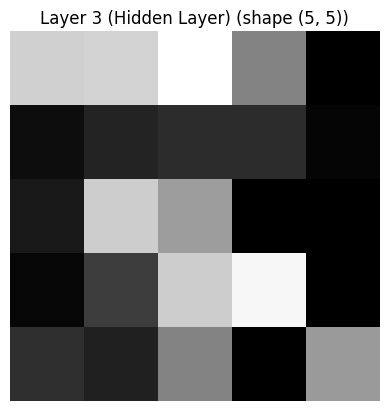

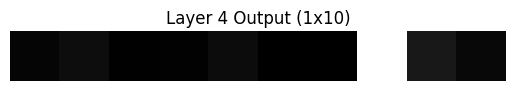


Epoch 56


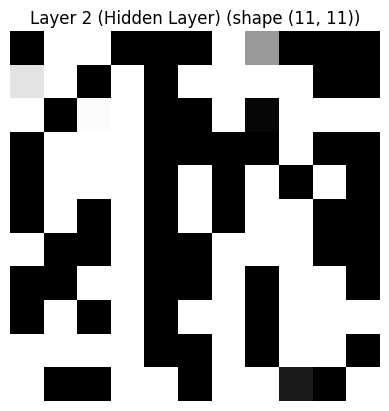

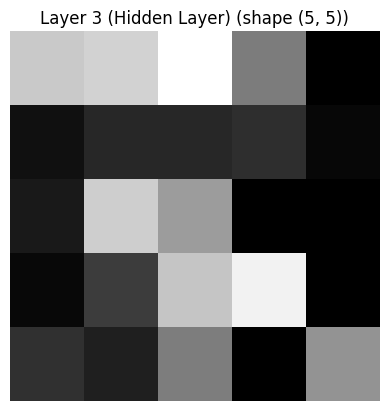

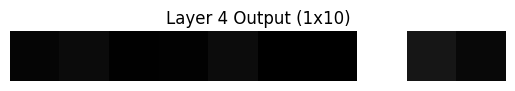


Epoch 57


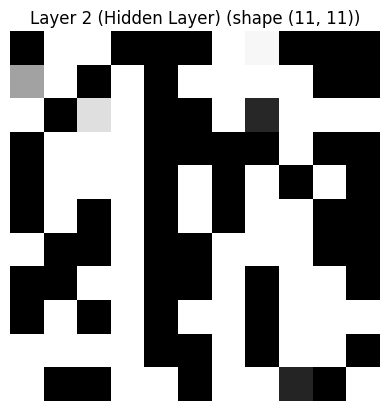

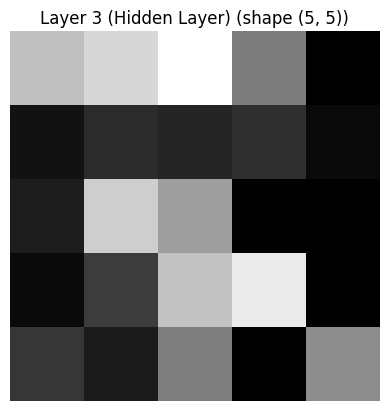

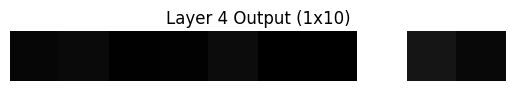


Epoch 58


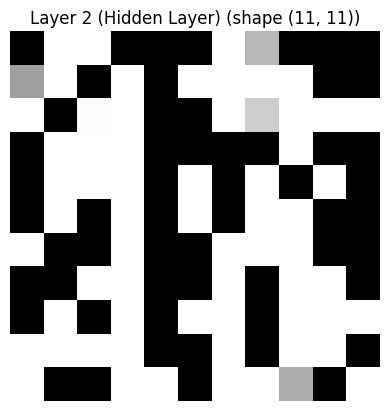

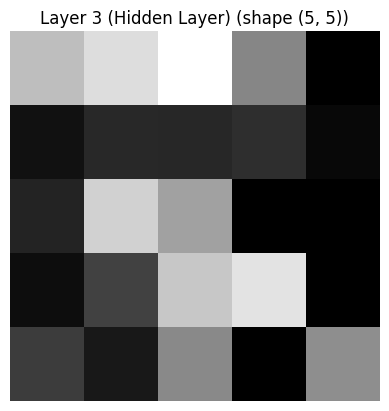

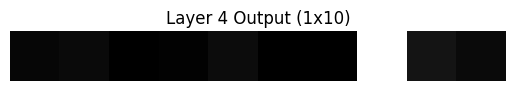


Epoch 59


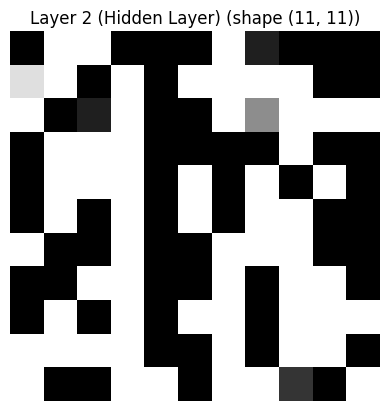

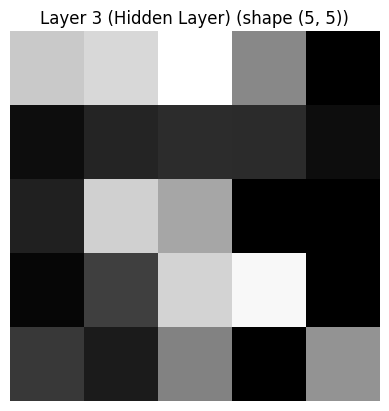

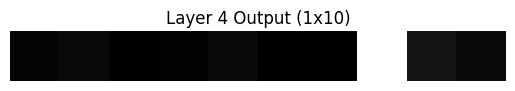


Epoch 60


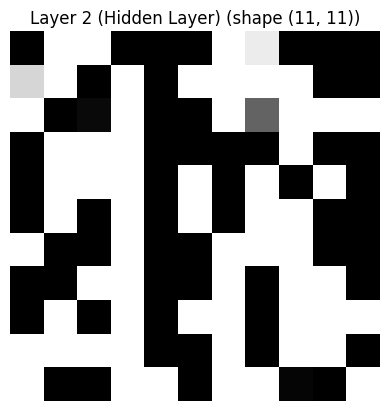

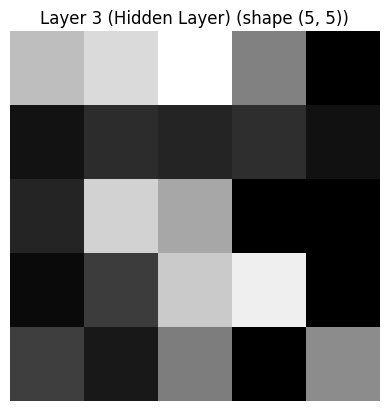

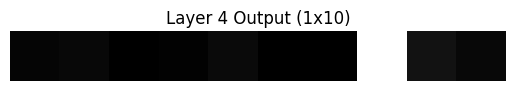


Epoch 61


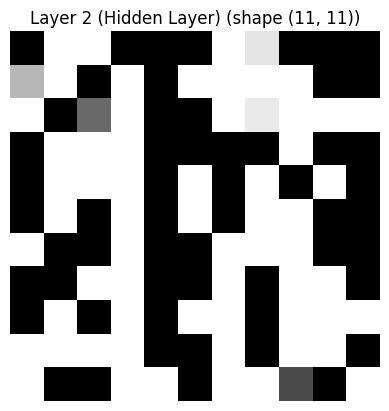

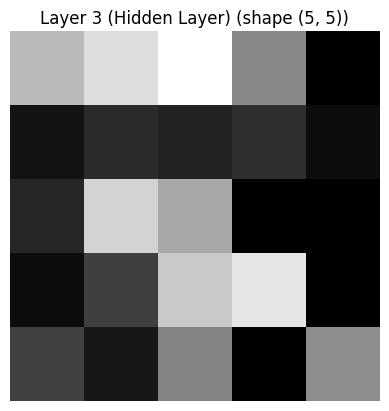

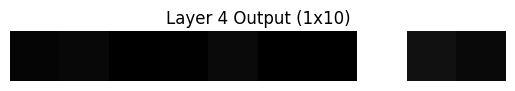


Epoch 62


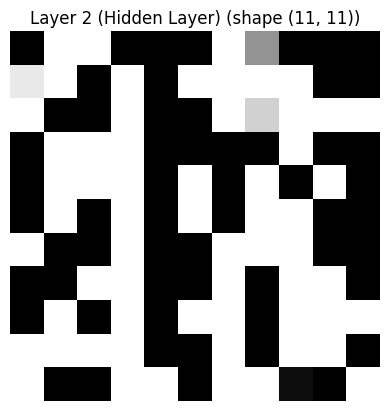

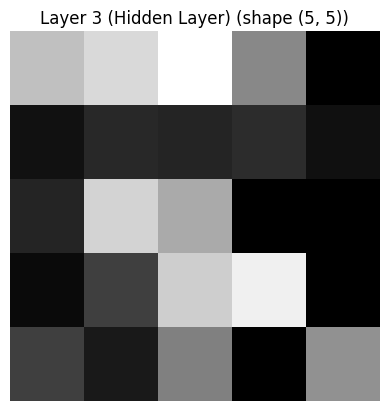

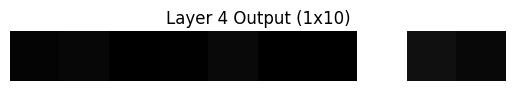


Epoch 63


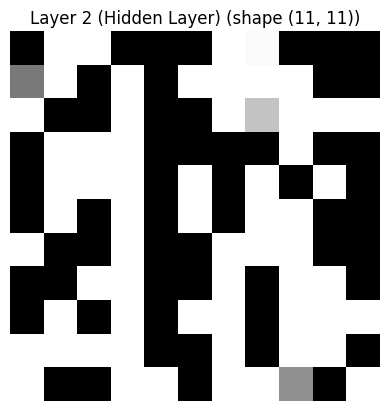

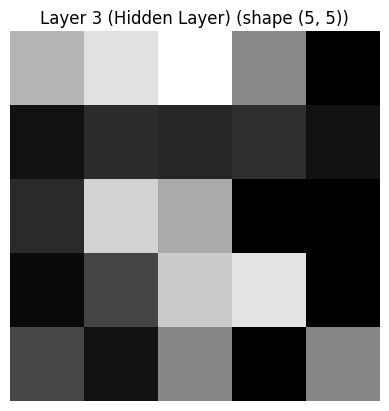

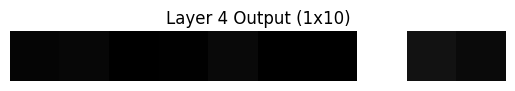


Epoch 64


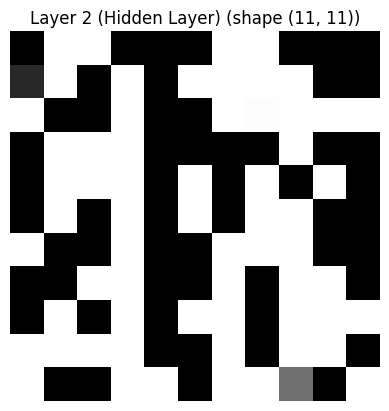

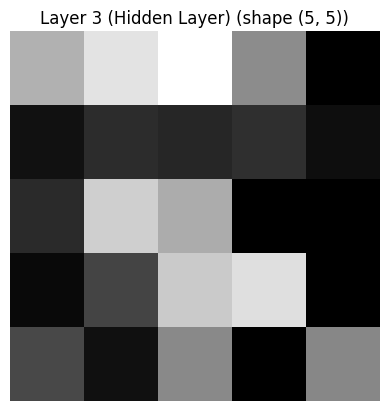

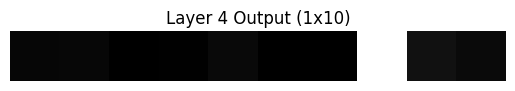


Epoch 65


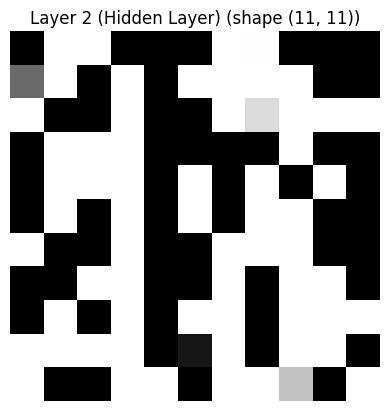

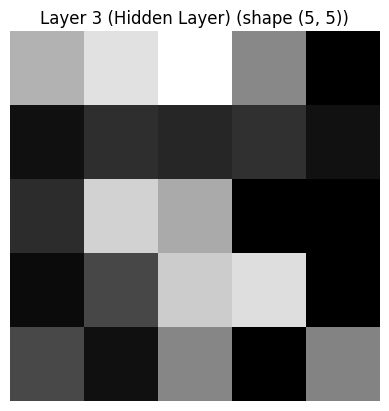

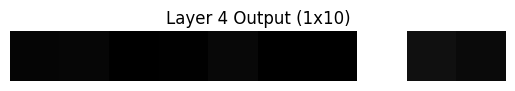


Epoch 66


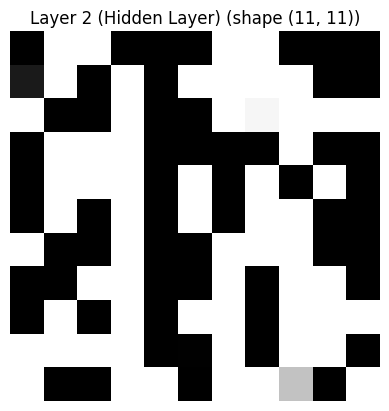

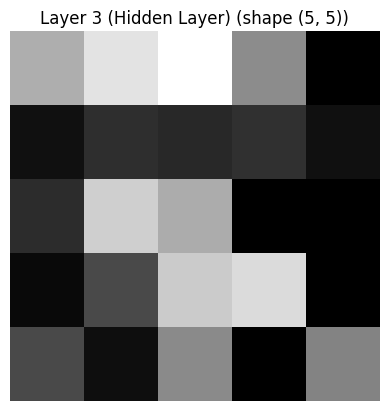

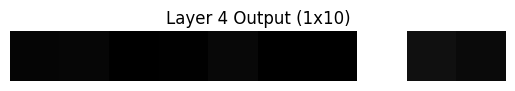


Epoch 67


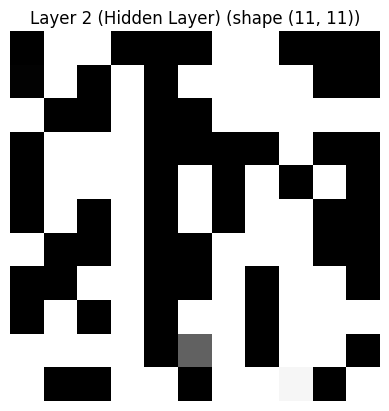

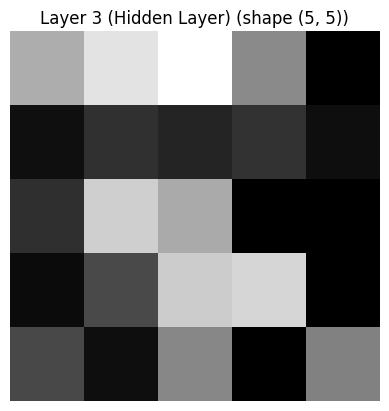

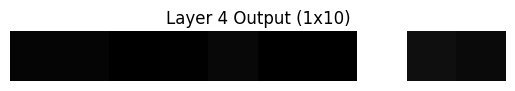


Epoch 68


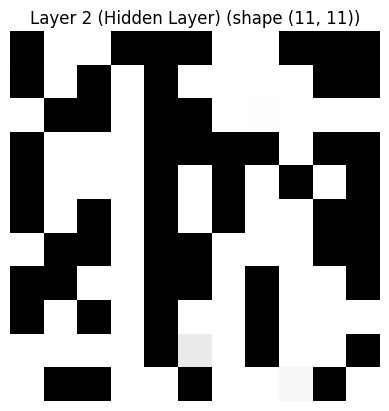

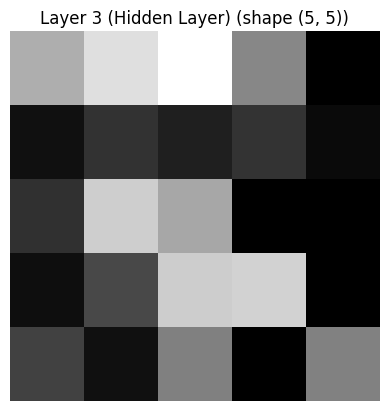

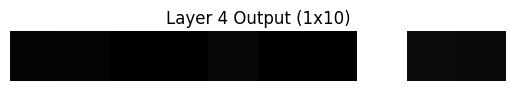


Epoch 69


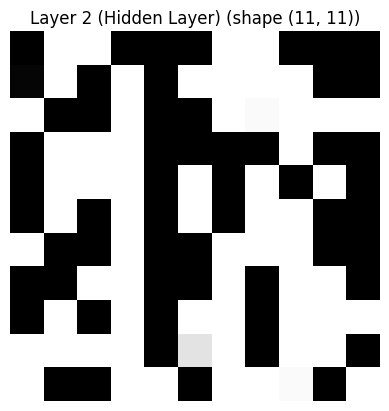

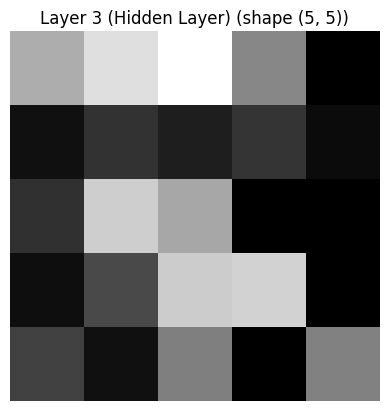

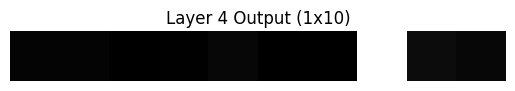


Epoch 70


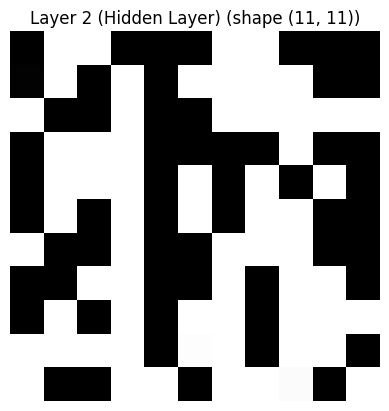

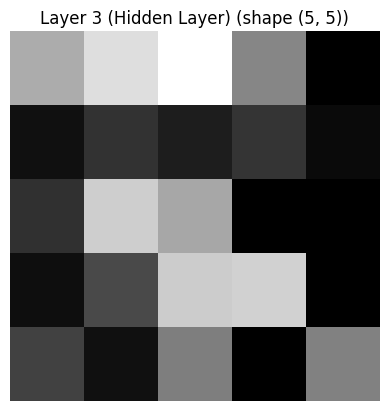

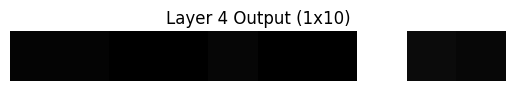


Epoch 71


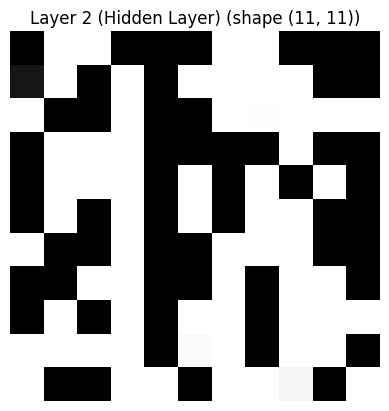

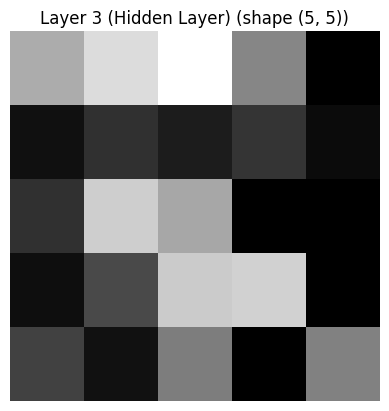

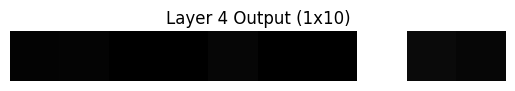


Epoch 72


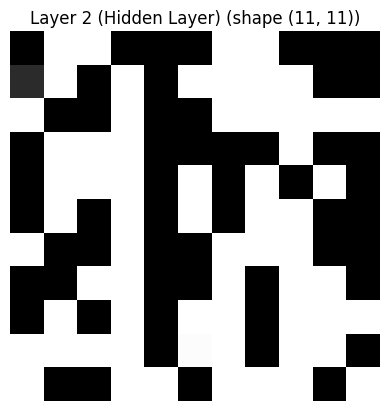

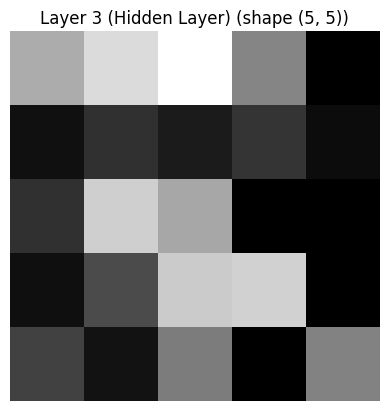

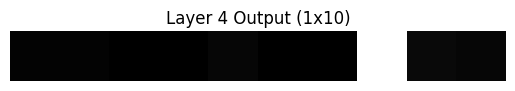


Epoch 73


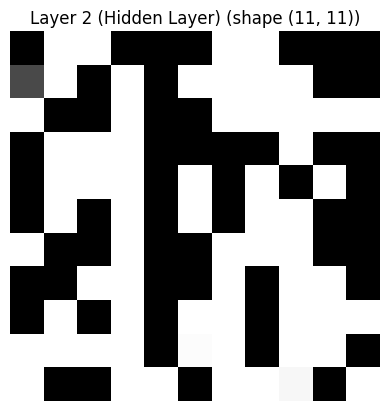

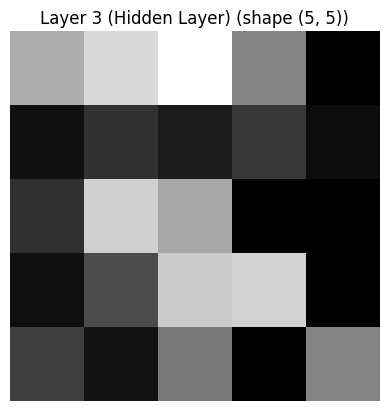

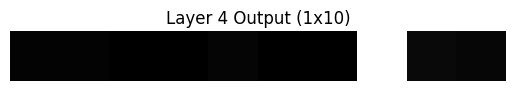


Epoch 74


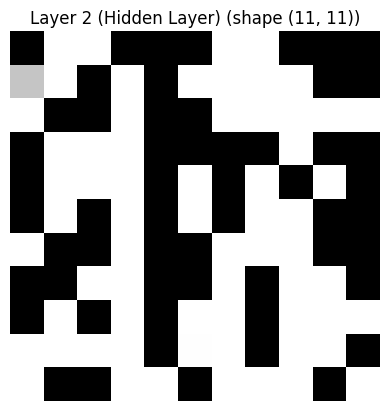

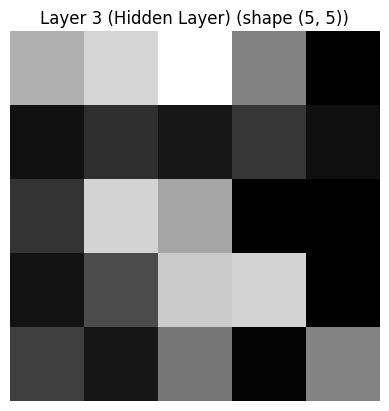

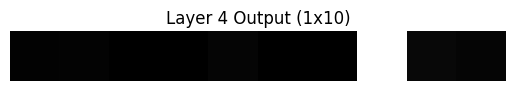


Epoch 75


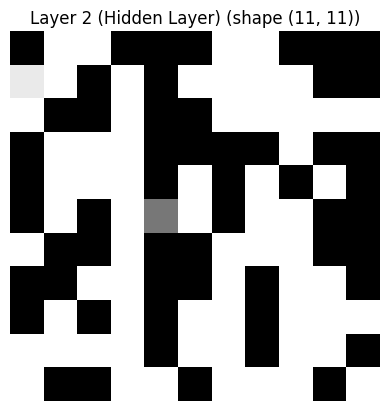

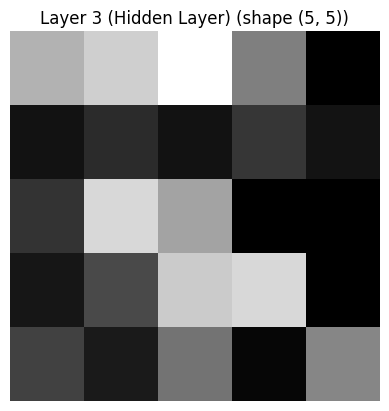

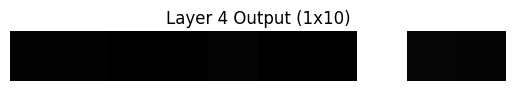


Epoch 76


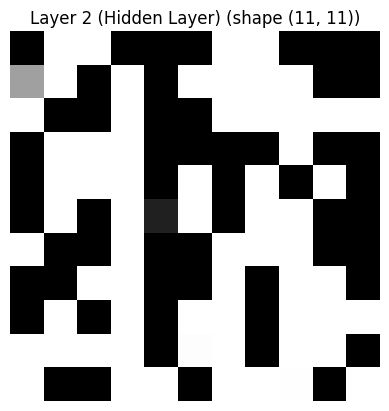

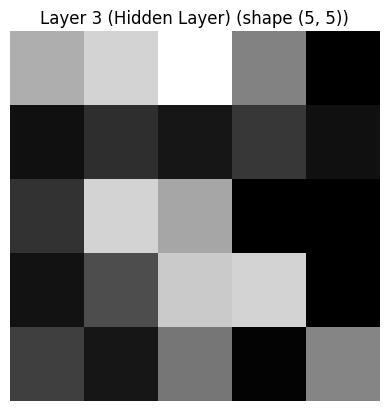

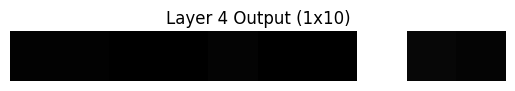


Epoch 77


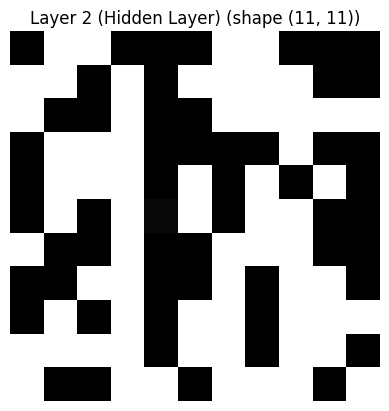

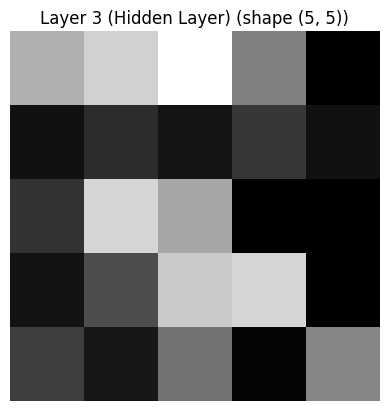

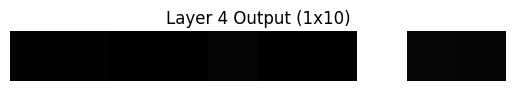


Epoch 78


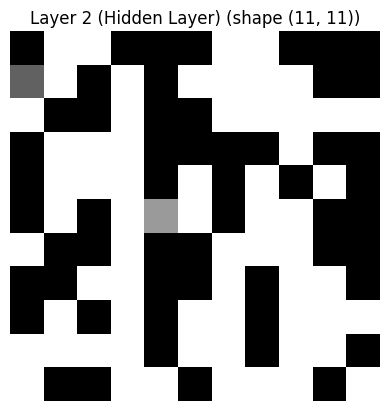

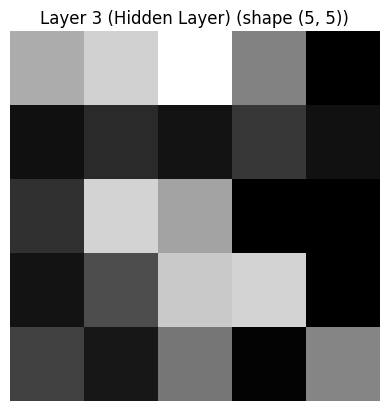

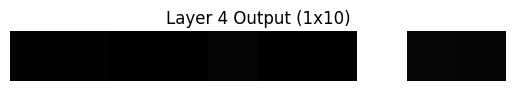


Epoch 79


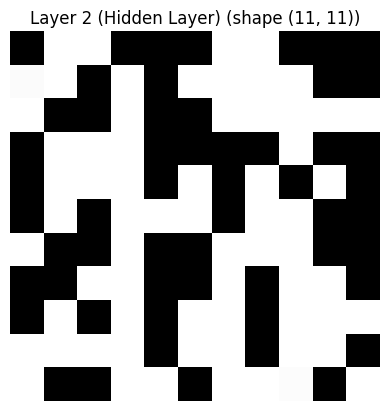

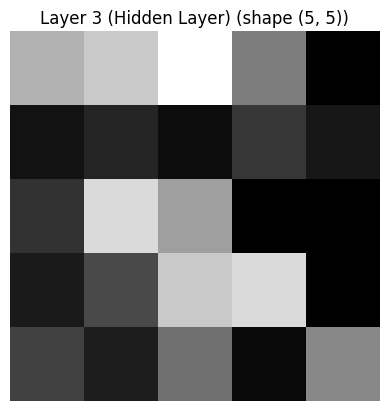

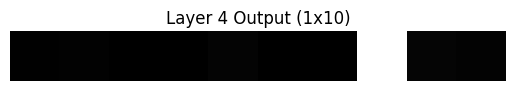


Epoch 80


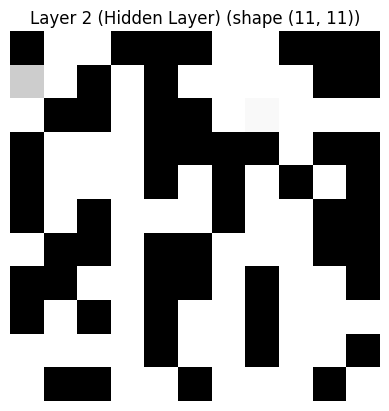

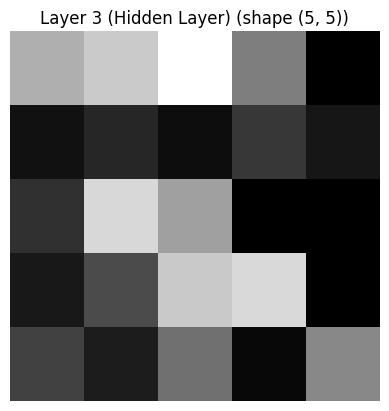

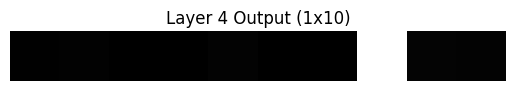


Epoch 81


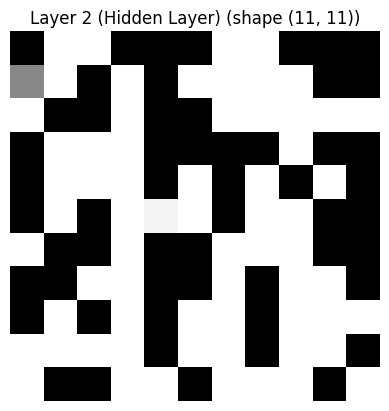

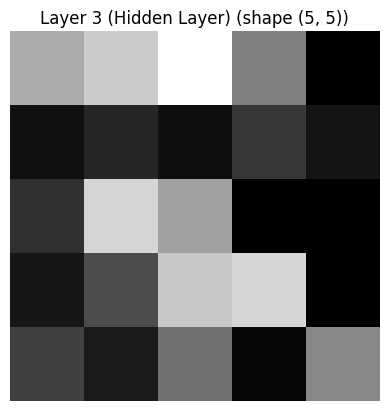

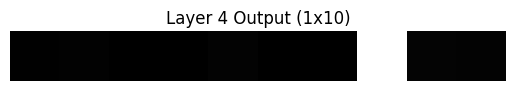


Epoch 82


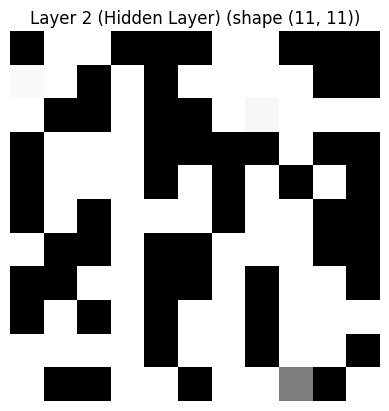

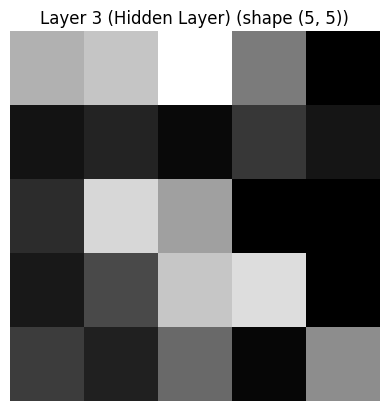

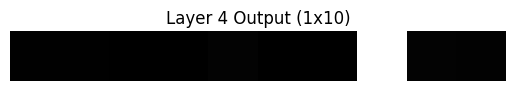


Epoch 83


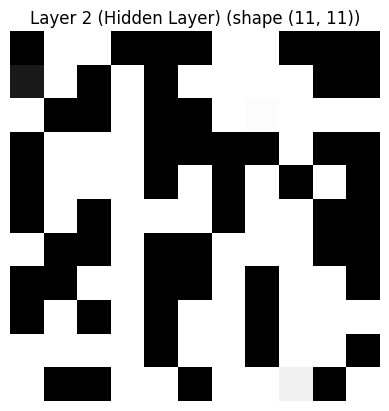

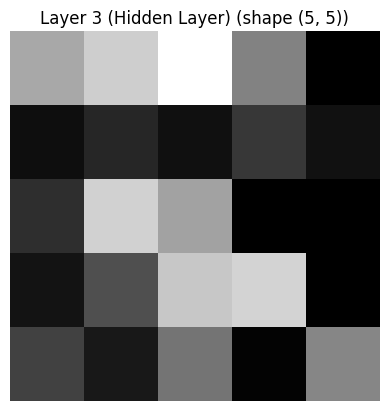

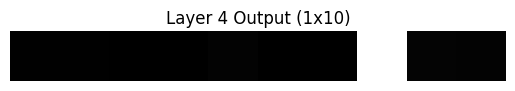


Epoch 84


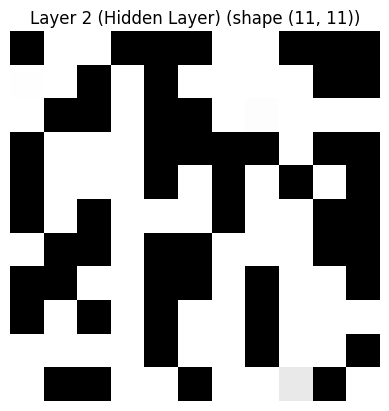

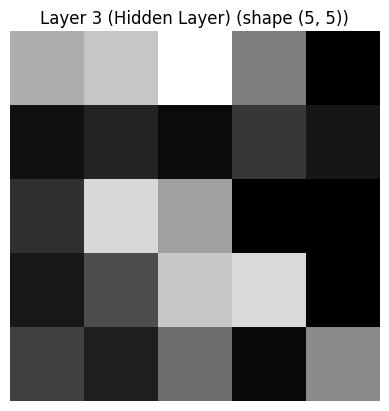

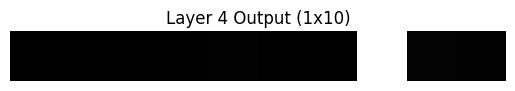


Epoch 85


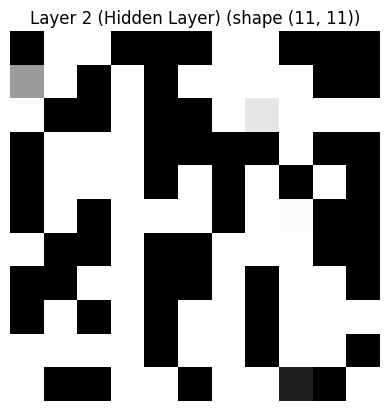

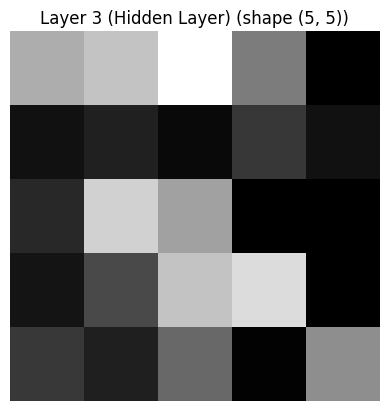

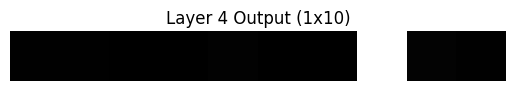


Epoch 86


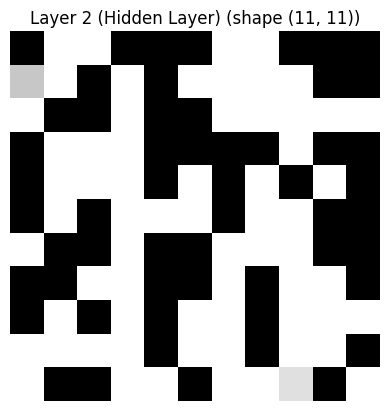

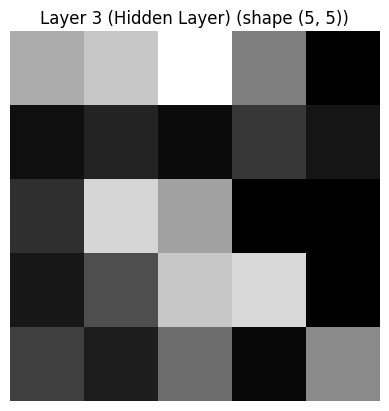

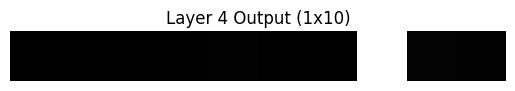


Epoch 87


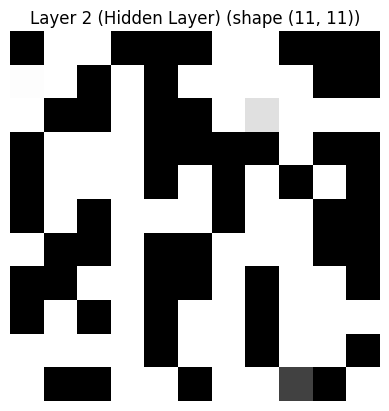

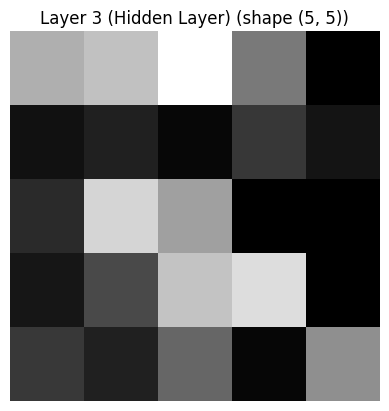

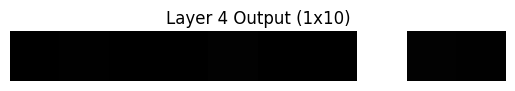


Epoch 88


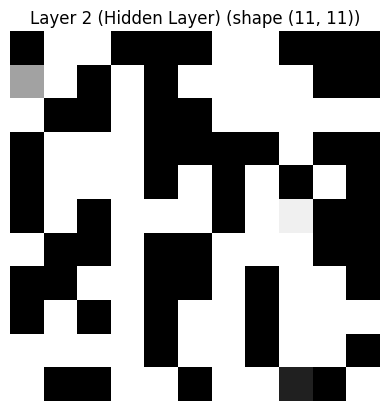

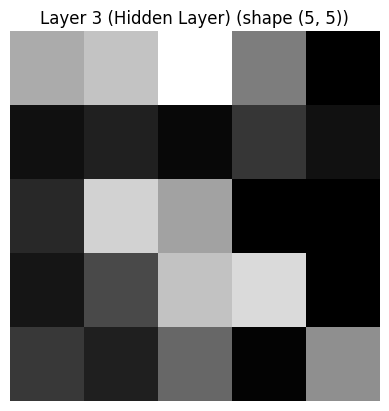

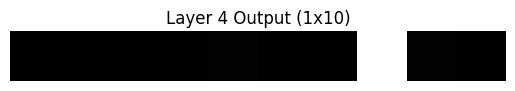


Epoch 89


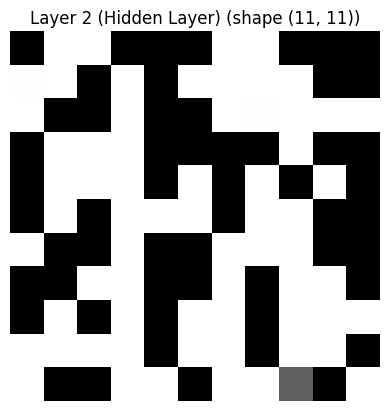

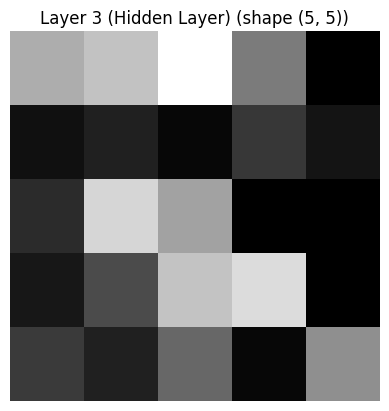

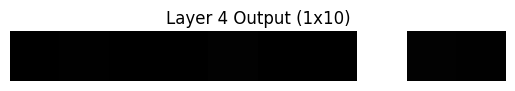


Epoch 90


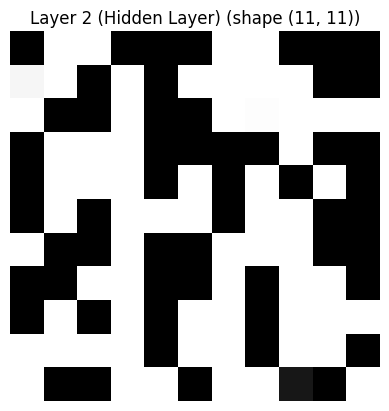

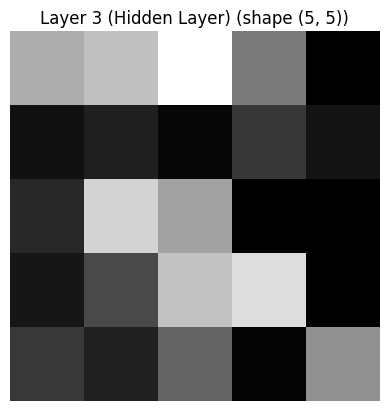

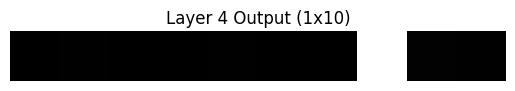


Epoch 91


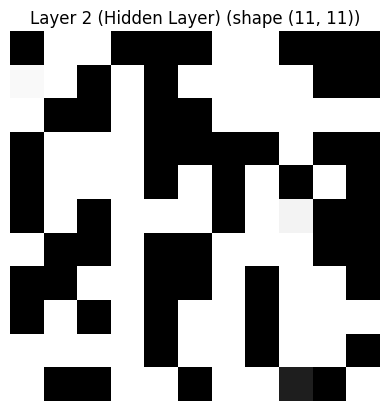

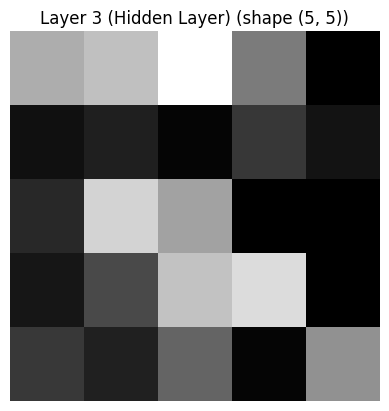

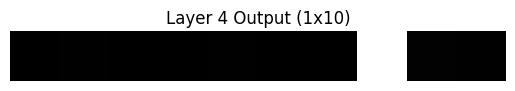


Epoch 92


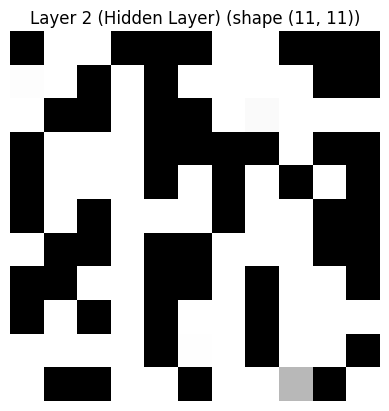

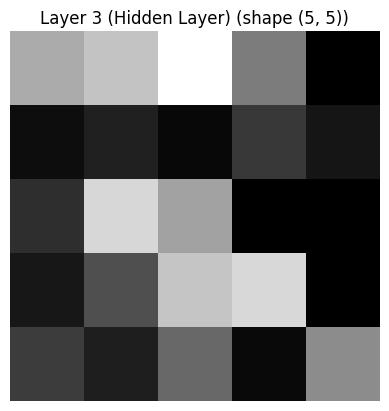

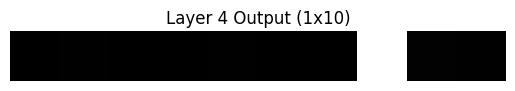


Epoch 93


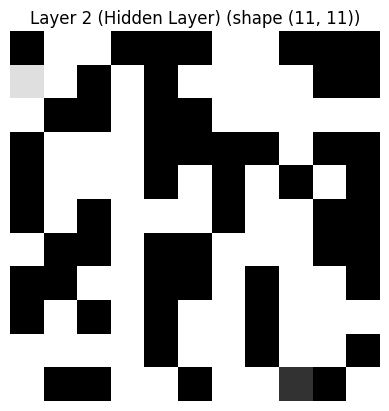

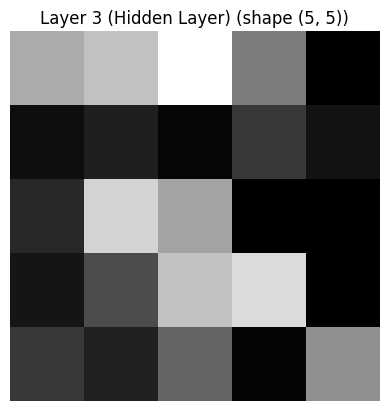

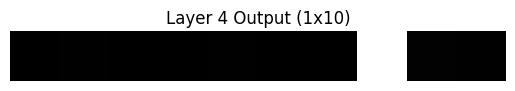


Epoch 94


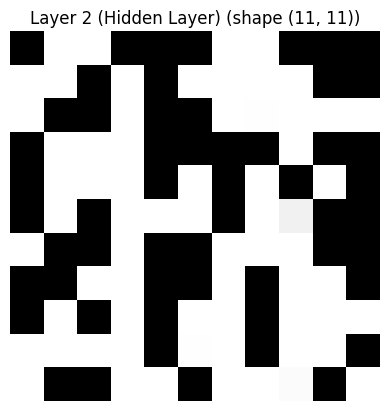

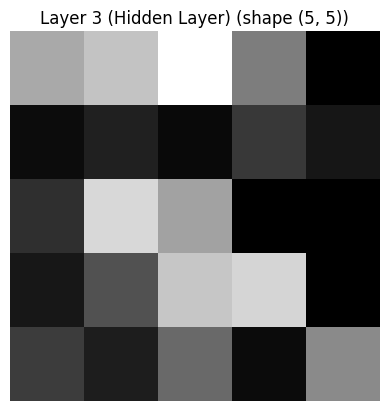

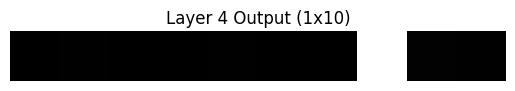


Epoch 95


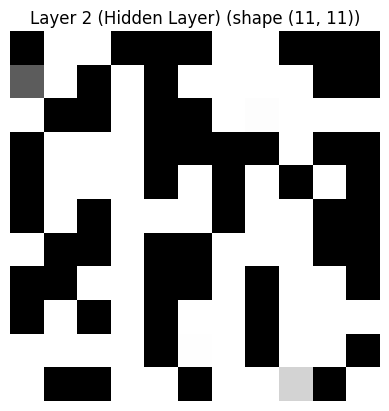

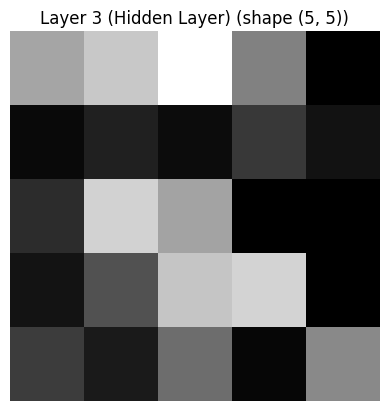

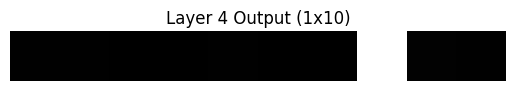


Epoch 96


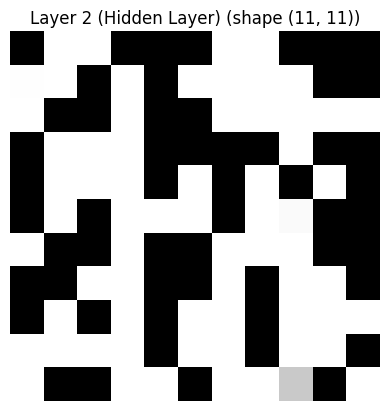

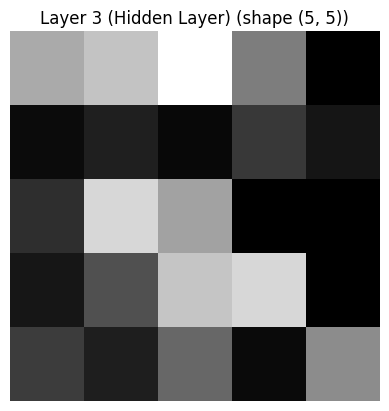

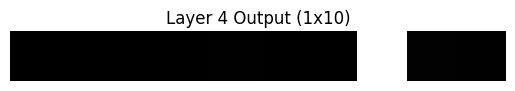


Epoch 97


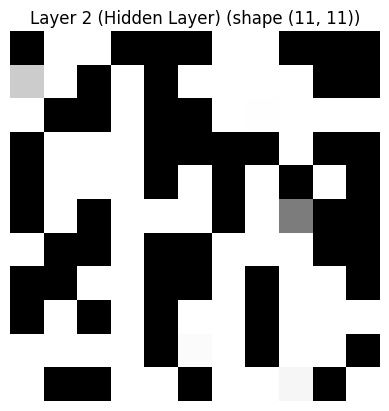

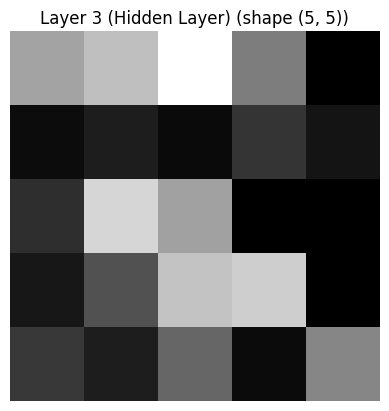

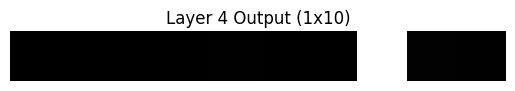


Epoch 98


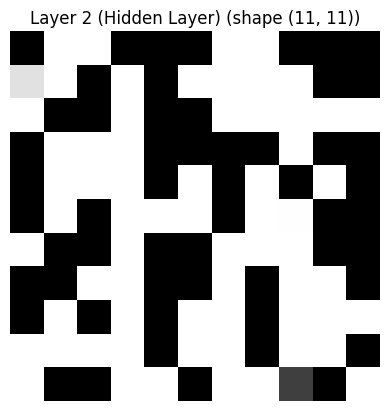

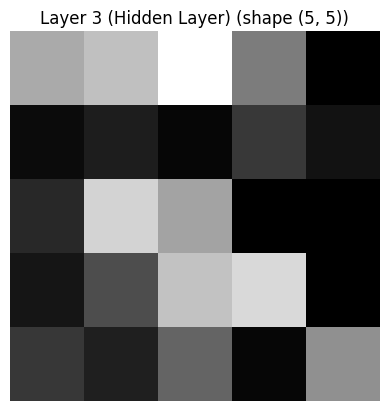

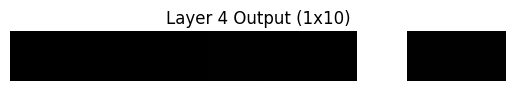


Epoch 99


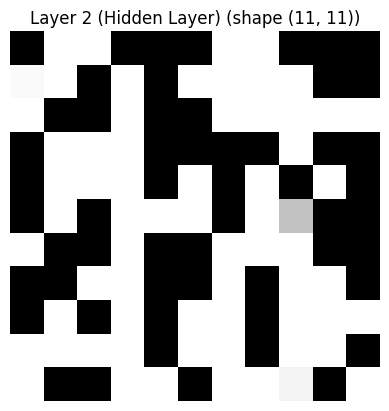

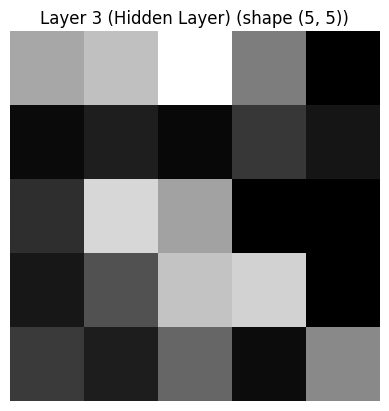

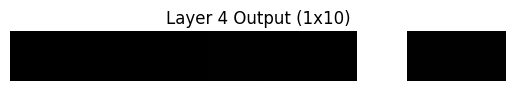


Epoch 100


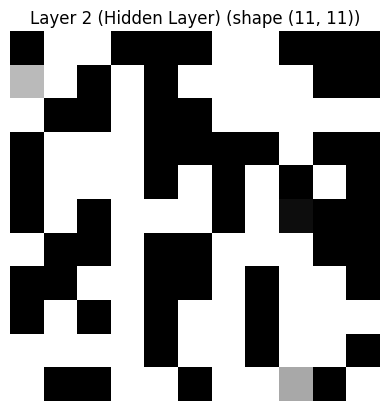

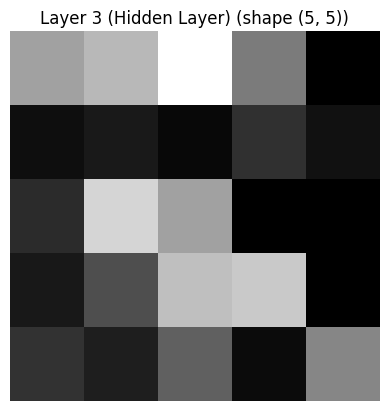

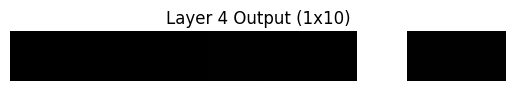

In [36]:
def show_activations(vector_db, layer_shapes, input_img=None):

    # Input image
    if input_img is not None:
        print("Input Image:")
        plt.figure()
        plt.imshow(input_img.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

    for epoch in vector_db:
        print(f"\nEpoch {epoch + 1}")
        for layer_idx, vec in vector_db[epoch].items():
            vec = vec.squeeze()
            shape = layer_shapes[layer_idx]
            plt.figure()
            layer_number = layer_idx + 2
            if len(shape) == 2:
                plt.imshow(vec.reshape(shape), cmap='gray')
                plt.title(f"Layer {layer_number} (Hidden Layer) (shape {shape})")
                plt.axis('off')
            else:
                # output image
                plt.imshow(vec.reshape(1, 10), cmap='gray')
                plt.title(f"Layer {layer_number} Output (1x10)")
                plt.axis('off')
            plt.show()

layer_shapes = {
    0: (11, 11),
    1: (5, 5),
    2: (10,)
}

# Usage:
show_activations(vector_db, layer_shapes, input_img=example_img)